Nome: Luiza Lober de Souza Piva, nUSP: 9302292

<hr>

# Inicialização

Pacotes que serão utilizados:

In [2]:
#Cálculos gerais, lidar com dados e gráficos
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.sparse as sp

#Redes e propagação de epidemias
import networkx as nx
import EoN

#Definição de características de maior impacto, parte final ([Extra])
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

Funções gerais

In [10]:
#Cálculo de momento
#--> O grau médio também pode ser entendido como o primeiro momento da rede. Logo,
def momento(G,n):
    M = 0       #inicializa a variável que conterá sum(G.degree(i)^m) como zero
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**n    #aplica o cálculo, vértice a vértice, com expoente de momento n
    M = M/N
    return M

In [11]:
def mais_conectado(G): #Essa função define qual é o vértice mais conectado para cada iteração de ataque.
  maxk = 0
  node = 0
  for i in G.nodes():
    if(G.degree(i) >= maxk):
      maxk = G.degree(i)
      node = i
  return node

## Redes e medidas básicas

Para definir quais parâmetros serão utilizados para inicializar as redes, me baseei no artigo [1]. Cada um desses parâmetros está comentado abaixo.

[1] S. Gómez et al 2010 EPL 89 38009, DOI: 10.1209/0295-5075/89/38009

In [9]:
#As redes que serão usadas:

#-> Parâmetros globais:
N = 1000    #Número de vértices, assim como no artigo fornecido.
grau_medio = 20    #os outros parâmetros serão ajustados de forma a manter esse valor para todas as redes

#-> ---  Barabási-Albert ---
m = int(grau_medio/2)    #Definimos m como a metade do grau médio de forma a não alterá-lo.
BA_graph = nx.barabasi_albert_graph(N, m, seed=42)
BA_graph.remove_edges_from(nx.selfloop_edges(BA_graph))   #aplicado em todas as redes. Garante que estaremos lidando com redes simples.

#-> --- Erdos-Reyni ---
p_ER = 0.02   #probabilidade de criação de arestas
ER_graph = nx.gnp_random_graph(N, p_ER, seed=42, directed=False)
ER_graph.remove_edges_from(nx.selfloop_edges(ER_graph))

#-> ---  Watts-Strogatz ---
p_WS = 0.3    #probabilidade de rewiring
k = 20        #número de conexões com os vizinhos
WS_graph = nx.watts_strogatz_graph(N, k, p_WS, seed=None)
WS_graph.remove_edges_from(nx.selfloop_edges(WS_graph))

#-> ---  Barabási-Albert não linear ---
p_BA = 0.05   #probabilidade de adicionar uma aresta entre os vértices.
q = 0.1       #probabilidade de rewiring
BA_nl_graph = nx.extended_barabasi_albert_graph(N, m, p_BA, q, seed=42)
BA_nl_graph.remove_edges_from(nx.selfloop_edges(BA_nl_graph))

Verificando o primeiro e segundo momento das redes anteriores:

In [ ]:
#Grau médio:
print('Grau médio')
print('Barabási-Albert:', "%3.1f"%momento(BA_graph,1))
print('Erdos-Reyni:', "%3.1f"%momento(ER_graph,1))
print('Watts-Strogatz:', "%3.1f"%momento(WS_graph,1))
print('Barabási-Albert não linear:', "%3.1f"%momento(BA_nl_graph,1))

print('---')
print('Segundo momento')
#Segundo momento:
print('Barabási-Albert:', "%3.1f"%momento(BA_graph,2))
print('Erdos-Reyni:', "%3.1f"%momento(ER_graph,2))
print('Watts-Strogatz:', "%3.1f"%momento(WS_graph,2))
print('Barabási-Albert não linear:', "%3.1f"%momento(BA_nl_graph,2))

Grau médio
Barabási-Albert: 19.8
Erdos-Reyni: 19.9
Watts-Strogatz: 20.0
Barabási-Albert não linear: 20.8
---
Segundo momento
Barabási-Albert: 708.2
Erdos-Reyni: 413.4
Watts-Strogatz: 404.7
Barabási-Albert não linear: 752.5


#Simulação da epidemia

## Modelo SIR

In [ ]:
#A função abaixo aplicará uma simulação tipo Gillespie do modelo SIR.
def simula_SIR(rede, betas, mu):
  '''
  Esta função aplicará uma simulação tipo Gillespie do modelo SIR de acordo com os valores de taxa de infecção
  --> contidos na lista 'betas'. Os valores observados são médias tomadas ao longo dos vértices da rede em estudo,
  --> de forma a observarmos um comportamento global, independente das propriedades específicas dos vértices que possam afetar
  --> a propagação da epidemia.

  -> rede: a rede a ser usada. A entrada esperada é nx.Graph().
  -> betas: lista com os valores de beta, ou taxa de transmissão, para rodar a simulação.
  -> mu: taxa de recuperação dos vértices. Valor único.
  '''
  #Inicializa os vetores que guardarão os valores médios de cada categoria do modelo,
  #-> e um contador para acompanhar o progresso da simulação.
  final_S_todos_vertices = []
  final_I_todos_vertices = []
  final_R_todos_vertices = []
  counter_beta = 1

  for beta in betas:
    print('Beta:', round(beta,2), '(', counter_beta, '/', len(betas), ')' )
    S_aux = []
    I_aux = []
    R_aux = []
    for node in rede.nodes():
      vt, vS, vI, vR = EoN.Gillespie_SIR(rede, beta, mu, initial_infecteds = node)    #aplica o modelo epidêmico SIR com o algoritmo Gillespie
      S_aux.append( vS[len(vS)-1] )   #Valor final dos vértices suscetíveis.
      I_aux.append( max(vI) )         #Aqui, queremos o pico de infectados ao invés do valor final.
      R_aux.append( vR[len(vR)-1] )

    #Tira uma média de todos os valores finais observados para cada vértice, e normaliza pelo total de vértices da rede.
    final_S_todos_vertices.append( np.mean(S_aux)/len(rede.nodes()) )
    final_I_todos_vertices.append( np.mean(I_aux)/len(rede.nodes()) )
    final_R_todos_vertices.append( np.mean(R_aux)/len(rede.nodes()) )
    counter_beta = counter_beta +1

  #Gera o dataframe resultante:
  data_epi = {'beta': betas, 'fracao_suscetiveis': final_S_todos_vertices,
              'fracao_infectados': final_I_todos_vertices, 'fracao_recuperados': final_R_todos_vertices}
  df = pd.DataFrame(data=data_epi)

  return df

In [ ]:
#Roda a função acima para as quatro redes
#-> parâmetros para a simulação:
betas = np.linspace(0, 1, 50)   #distribuição uniforme das taxas de infeção que serão testadas.
mu = 1      #poderiam ser estudados os efeitos não-lineares de usar mu!=1, mas isso tornaria o trabalho bastante extenso.
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]     #"concatena" as redes que serão utilizadas num vetor para fácil acesso.
redes_nomes = ['BA', 'ER', 'WS', 'BA-NL']                     #Salva o nome dessas redes.
df_res = pd.DataFrame()

for n in range(len(todas_redes)):      #executa a simulação para cada tipo de rede.
  print('---> Rede:', redes_nomes[n])
  aux = simula_SIR(todas_redes[n], betas, mu)
  aux['rede'] = np.tile(redes_nomes[n], len(betas))   #adiciona uma lista com rótulos de tamanho len(betas), ou tamanho resultante do dataframe, contendo o nome de cada rede usada.
  df_res = pd.concat([df_res, aux])

#Salva o dataframe resultante
df_res.to_csv('processos_epi_SIR_fracoes-vs-beta_1000N.csv')

#Obs: tempo de simulação: 29 minutos.

---> Rede: BA
Beta: 0.0 ( 1 / 50 )
Beta: 0.02 ( 2 / 50 )
Beta: 0.04 ( 3 / 50 )
Beta: 0.06 ( 4 / 50 )
Beta: 0.08 ( 5 / 50 )
Beta: 0.1 ( 6 / 50 )
Beta: 0.12 ( 7 / 50 )
Beta: 0.14 ( 8 / 50 )
Beta: 0.16 ( 9 / 50 )
Beta: 0.18 ( 10 / 50 )
Beta: 0.2 ( 11 / 50 )
Beta: 0.22 ( 12 / 50 )
Beta: 0.24 ( 13 / 50 )
Beta: 0.27 ( 14 / 50 )
Beta: 0.29 ( 15 / 50 )
Beta: 0.31 ( 16 / 50 )
Beta: 0.33 ( 17 / 50 )
Beta: 0.35 ( 18 / 50 )
Beta: 0.37 ( 19 / 50 )
Beta: 0.39 ( 20 / 50 )
Beta: 0.41 ( 21 / 50 )
Beta: 0.43 ( 22 / 50 )
Beta: 0.45 ( 23 / 50 )
Beta: 0.47 ( 24 / 50 )
Beta: 0.49 ( 25 / 50 )
Beta: 0.51 ( 26 / 50 )
Beta: 0.53 ( 27 / 50 )
Beta: 0.55 ( 28 / 50 )
Beta: 0.57 ( 29 / 50 )
Beta: 0.59 ( 30 / 50 )
Beta: 0.61 ( 31 / 50 )
Beta: 0.63 ( 32 / 50 )
Beta: 0.65 ( 33 / 50 )
Beta: 0.67 ( 34 / 50 )
Beta: 0.69 ( 35 / 50 )
Beta: 0.71 ( 36 / 50 )
Beta: 0.73 ( 37 / 50 )
Beta: 0.76 ( 38 / 50 )
Beta: 0.78 ( 39 / 50 )
Beta: 0.8 ( 40 / 50 )
Beta: 0.82 ( 41 / 50 )
Beta: 0.84 ( 42 / 50 )
Beta: 0.86 ( 43 / 50 )
Beta: 0.88

### Figuras

Aqui, vamos analisar a fração de recuperados, suscetíveis e infectados de acordo com as topologias de rede testadas.

Nota: uso siglas para denominar as redes,

* 'BA': Barabási-Albert;

* 'ER': Erdos-Reyni;

* 'WS': Watts-Strogatz;

* 'BA-NL': Barabási-Albert não linear, ou extendido.

O mesmo padrão seguirá para as demais células desse notebook.

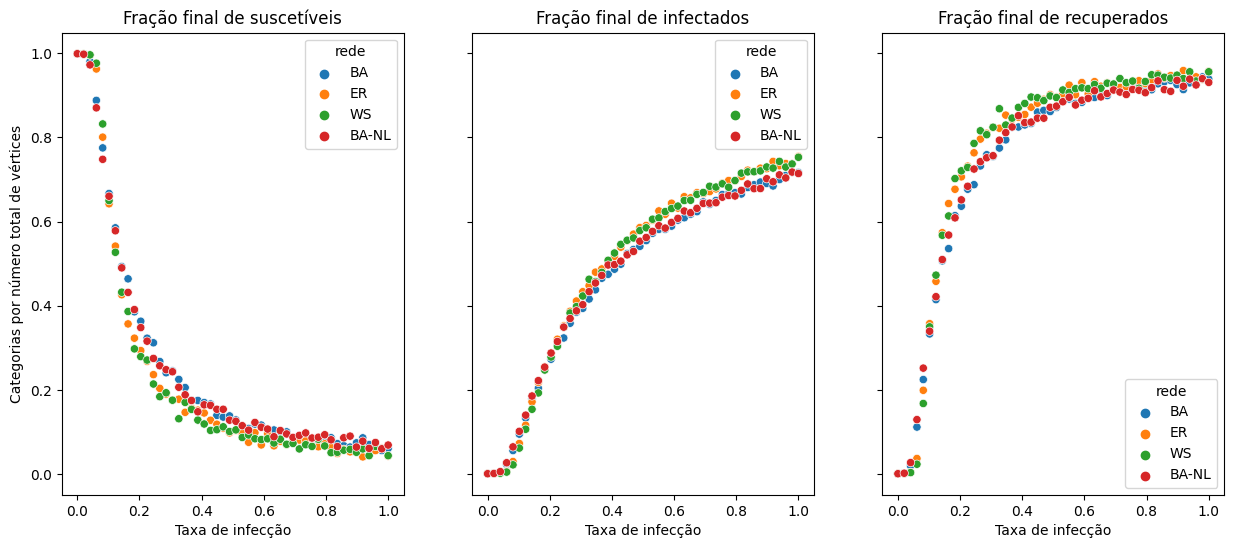

In [4]:
#Cria um gráfico de três partes para visualizar as frações obtidas para cada uma das categorias ("S", "I" e "R") do modelo.
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,6))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='beta', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de infecção')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='beta', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração máxima de infectados')
ax[1].set_xlabel('Taxa de infecção')

#Parte 3: Fração de recuperados
sns.scatterplot(x='beta', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Taxa de infecção')

plt.show()

Podemos observar que há um crescimento não linear para a fração final de infectados e recuperados conforme o aumento da taxa de infecção, e um decréscimo no caso da fração final de suscetíveis.

Nos três gráficos acima, note que a epidemia se propaga somente a partir do valor $\beta \approx 0.07$. Será mostrado posteriormente que há uma dependência entre esse valor de percolação e a maior componente do gráfico.

Além disso, há uma diferença, apesar de sutil, entre as topologias: as redes Barabási-Albert apresentam um efeito atenuado na variação de cada uma das frações, enquanto a rede Watts-Strogatz é a que mais altera essas frações conforme o aumento em $\beta$.

**Observação**: Como a fração de infectados mostra os valores máximos observados na rede, em média, cada ponto de S, I e R em $\beta$ não somará 1 como esperado para o modelo SIR. Essa escolha foi feita por conta do critério de parada da simulação, que é justamente `tax_final_infectados = 0`. Portanto, o esperado para as taxas finais é $r_S + r_R = 1$.

O mesmo será verdade para todos os outros modelos SIR, ou derivados do mesmo, que serão apresentados.

## Modelo SIS

In [ ]:
def simula_SIS(rede, betas, mu, max_time):
  '''
  Esta função aplicará uma simulação tipo Gillespie do modelo SIS de acordo com os valores de taxa de infecção
  --> contidos na lista 'betas'. Os valores observados são médias tomadas ao longo dos vértices da rede em estudo,
  --> de forma a observarmos um comportamento global, independente das propriedades específicas dos vértices que possam afetar
  --> a propagação da epidemia.

  -> rede: a rede a ser usada. A entrada esperada é nx.Graph();
  -> betas: lista com os valores de beta, ou taxa de transmissão, para rodar a simulação;
  -> mu: taxa de recuperação dos vértices. Valor único;
  -> max_time: tempo limite para cada simulação. O algoritmo para SIS é significativamente;
  --> mais lento que o do modelo SIR, o que faz essa modificação ser necessária.
  '''
  #Inicializa os vetores que guardarão os valores médios de cada categoria do modelo,
  #-> e um contador para acompanhar o progresso da simulação.
  final_S_todos_vertices = []
  final_I_todos_vertices = []
  contador_betas = 1

  for beta in betas:
    print('Beta:', round(beta,2), '(', contador_betas, '/', len(betas), ')' )
    S_aux = []
    I_aux = []
    for node in rede.nodes():
      vt, vS, vI = EoN.Gillespie_SIS(rede, beta, mu, initial_infecteds = node, tmax=max_time)   #aplica o modelo epidêmico SIS com o algoritmo Gillespie
      S_aux.append( vS[len(vS)-1] )
      I_aux.append( vI[len(vI)-1] )

    #Tira uma média de todos os valores finais observados para cada vértice, e normaliza pelo total de vértices da rede.
    final_S_todos_vertices.append( np.mean(S_aux)/len(rede.nodes()) )
    final_I_todos_vertices.append( np.mean(I_aux)/len(rede.nodes()) )
    contador_betas = contador_betas +1

  #Gera o dataframe resultante:
  data_epi = {'beta': betas, 'fracao_suscetiveis': final_S_todos_vertices,
              'fracao_infectados': final_I_todos_vertices}
  df = pd.DataFrame(data=data_epi)

  return df

In [ ]:
#Roda a função acima para as quatro redes
#-> Parâmetros para a simulação:
betas = np.linspace(0, 1, 20)   #distribuição uniforme das taxas de infeção que serão testadas.
mu = 1      #poderiam ser estudados os efeitos não-lineares de usar mu!=1, mas isso tornaria o trabalho bastante extenso.
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]    #"concatena" as redes que serão utilizadas num vetor para fácil acesso.
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']                      #Salva o nome dessas redes.
df_res = pd.DataFrame()

#executa a simulação para cada tipo de rede.
for n in range(len(todas_redes)):
  print('---> Rede:', net_nomes[n])
  aux = simula_SIS(todas_redes[n], betas, mu, max_time=20)
  #Abaixo, adiciona uma lista com rótulos de tamanho len(betas), ou tamanho resultante do dataframe, contendo o nome de cada rede usada.
  aux['rede'] = np.tile(net_nomes[n], len(betas))

  df_res = pd.concat([df_res, aux])

#Salva o dataframe resultante
df_res.to_csv('processos_epi_SIS_fracoes-vs-beta_1000N.csv')

#Tempo de execução: ~4h30m

---> Rede: BA
Beta: 0.0 ( 1 / 20 )
Beta: 0.05 ( 2 / 20 )
Beta: 0.11 ( 3 / 20 )
Beta: 0.16 ( 4 / 20 )
Beta: 0.21 ( 5 / 20 )
Beta: 0.26 ( 6 / 20 )
Beta: 0.32 ( 7 / 20 )
Beta: 0.37 ( 8 / 20 )
Beta: 0.42 ( 9 / 20 )
Beta: 0.47 ( 10 / 20 )
Beta: 0.53 ( 11 / 20 )
Beta: 0.58 ( 12 / 20 )
Beta: 0.63 ( 13 / 20 )
Beta: 0.68 ( 14 / 20 )
Beta: 0.74 ( 15 / 20 )
Beta: 0.79 ( 16 / 20 )
Beta: 0.84 ( 17 / 20 )
Beta: 0.89 ( 18 / 20 )
Beta: 0.95 ( 19 / 20 )
Beta: 1.0 ( 20 / 20 )
---> Rede: ER
Beta: 0.0 ( 1 / 20 )
Beta: 0.05 ( 2 / 20 )
Beta: 0.11 ( 3 / 20 )
Beta: 0.16 ( 4 / 20 )
Beta: 0.21 ( 5 / 20 )
Beta: 0.26 ( 6 / 20 )
Beta: 0.32 ( 7 / 20 )
Beta: 0.37 ( 8 / 20 )
Beta: 0.42 ( 9 / 20 )
Beta: 0.47 ( 10 / 20 )
Beta: 0.53 ( 11 / 20 )
Beta: 0.58 ( 12 / 20 )
Beta: 0.63 ( 13 / 20 )
Beta: 0.68 ( 14 / 20 )
Beta: 0.74 ( 15 / 20 )
Beta: 0.79 ( 16 / 20 )
Beta: 0.84 ( 17 / 20 )
Beta: 0.89 ( 18 / 20 )
Beta: 0.95 ( 19 / 20 )
Beta: 1.0 ( 20 / 20 )
---> Rede: WS
Beta: 0.0 ( 1 / 20 )
Beta: 0.05 ( 2 / 20 )
Beta: 0.11 ( 3 / 

### Figuras

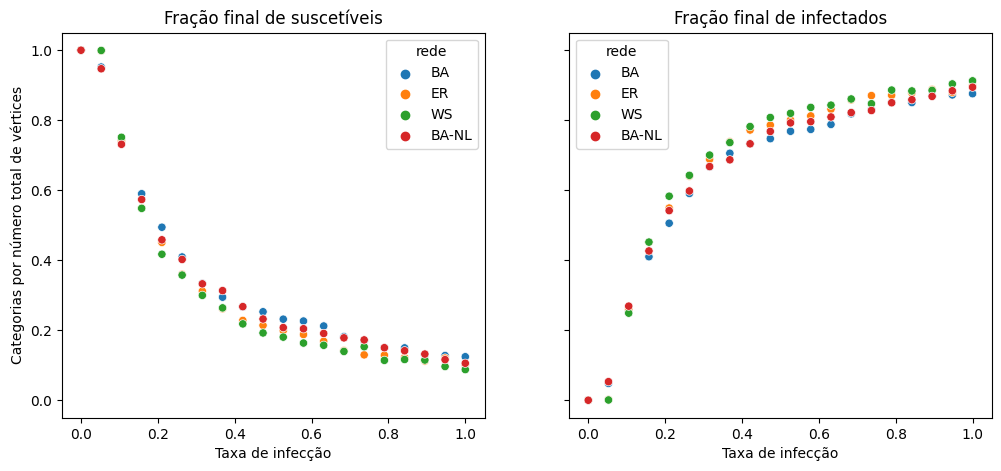

In [6]:
#Cria um gráfico de duas partes para visualizar as frações obtidas para cada uma das categorias ("S" e "I") do modelo.
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,5))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='beta', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de infecção')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='beta', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração final de infectados')
ax[1].set_xlabel('Taxa de infecção')

plt.show()

Nesse caso, podemos observar que a epidemia também começa a se propagar a partir de $\beta \approx 0.07$, apesar de maneiras distintas para cada topologia, o que indica que essa taxa de "corte" para a epidemia é uma característica associada a uma das propriedades compartilhadas por elas: que nesse estudo deve necessariamente ser o grau médio.

Por conta disso, vamos executar novamente os testes com SIR e SIS e redes de grau $k=5$, mas somente na região de transição [0, 0.2].

## Comparação com a transição observada na região [0, 0.2] com redes de $<k> = 6$

In [ ]:
#Roda a função acima para as quatro redes
#-> parâmetros para a simulação:
betas = np.linspace(0, 0.2, 50)   #distribuição uniforme das taxas de infeção que serão testadas.
mu = 1      #poderiam ser estudados os efeitos não-lineares de usar mu!=1, mas isso tornaria o trabalho bastante extenso.
todas_redes = [BA_graph_teste, ER_graph_teste, WS_graph_teste, BA_nl_graph_teste]     #"concatena" as redes que serão utilizadas num vetor para fácil acesso.
redes_nomes = ['BA_k=6', 'ER_k=6', 'WS_k=6', 'BA-NL_k=6']                     #Salva o nome dessas redes.
df_res = pd.DataFrame()

for n in range(len(todas_redes)):      #executa a simulação para cada tipo de rede.
  print('---> Rede:', redes_nomes[n])
  aux = simula_SIR(todas_redes[n], betas, mu)
  aux['rede'] = np.tile(redes_nomes[n], len(betas))   #adiciona uma lista com rótulos de tamanho len(betas), ou tamanho resultante do dataframe, contendo o nome de cada rede usada.
  df_res = pd.concat([df_res, aux])

#Salva o dataframe resultante
df_res.to_csv('processos_epi_SIR_fracoes-vs-beta-transicao_1000N.csv')

#Obs: tempo de simulação: 15 segundos.

---> Rede: BA_k=6
Beta: 0.0 ( 1 / 50 )
Beta: 0.0 ( 2 / 50 )
Beta: 0.01 ( 3 / 50 )
Beta: 0.01 ( 4 / 50 )
Beta: 0.02 ( 5 / 50 )
Beta: 0.02 ( 6 / 50 )
Beta: 0.02 ( 7 / 50 )
Beta: 0.03 ( 8 / 50 )
Beta: 0.03 ( 9 / 50 )
Beta: 0.04 ( 10 / 50 )
Beta: 0.04 ( 11 / 50 )
Beta: 0.04 ( 12 / 50 )
Beta: 0.05 ( 13 / 50 )
Beta: 0.05 ( 14 / 50 )
Beta: 0.06 ( 15 / 50 )
Beta: 0.06 ( 16 / 50 )
Beta: 0.07 ( 17 / 50 )
Beta: 0.07 ( 18 / 50 )
Beta: 0.07 ( 19 / 50 )
Beta: 0.08 ( 20 / 50 )
Beta: 0.08 ( 21 / 50 )
Beta: 0.09 ( 22 / 50 )
Beta: 0.09 ( 23 / 50 )
Beta: 0.09 ( 24 / 50 )
Beta: 0.1 ( 25 / 50 )
Beta: 0.1 ( 26 / 50 )
Beta: 0.11 ( 27 / 50 )
Beta: 0.11 ( 28 / 50 )
Beta: 0.11 ( 29 / 50 )
Beta: 0.12 ( 30 / 50 )
Beta: 0.12 ( 31 / 50 )
Beta: 0.13 ( 32 / 50 )
Beta: 0.13 ( 33 / 50 )
Beta: 0.13 ( 34 / 50 )
Beta: 0.14 ( 35 / 50 )
Beta: 0.14 ( 36 / 50 )
Beta: 0.15 ( 37 / 50 )
Beta: 0.15 ( 38 / 50 )
Beta: 0.16 ( 39 / 50 )
Beta: 0.16 ( 40 / 50 )
Beta: 0.16 ( 41 / 50 )
Beta: 0.17 ( 42 / 50 )
Beta: 0.17 ( 43 / 50 )
Beta: 

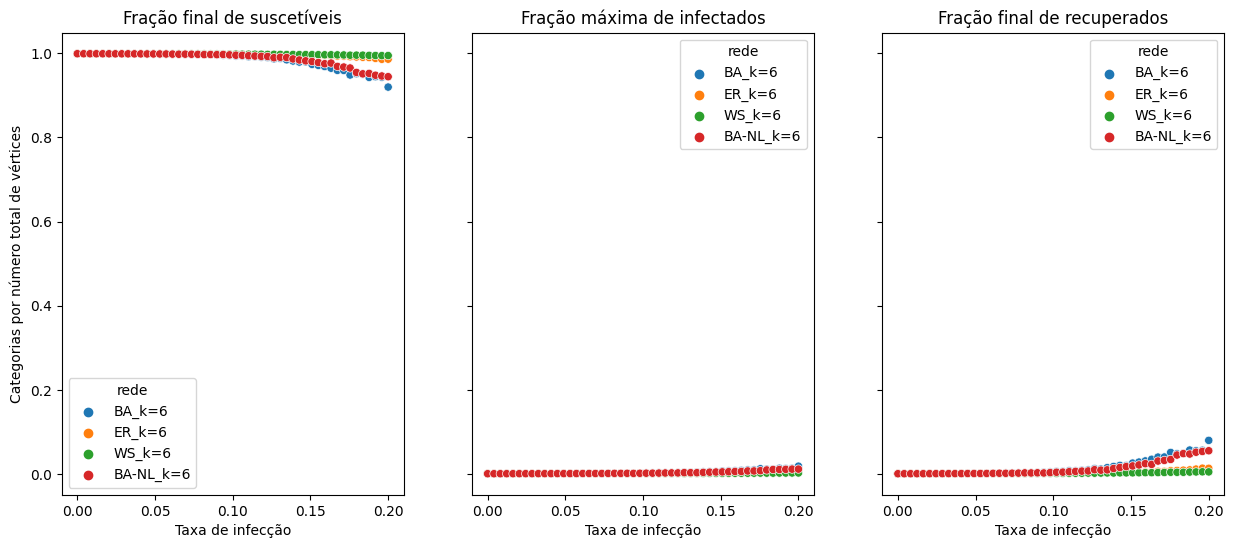

In [28]:
#Cria um gráfico de três partes para visualizar as frações obtidas para cada uma das categorias ("S", "I" e "R") do modelo.
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,6))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='beta', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de infecção')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='beta', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração máxima de infectados')
ax[1].set_xlabel('Taxa de infecção')

#Parte 3: Fração de recuperados
sns.scatterplot(x='beta', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Taxa de infecção')

plt.show()

In [ ]:
#Roda a função acima para as quatro redes
#-> Parâmetros para a simulação:
betas = np.linspace(0, 0.2, 20)   #distribuição uniforme das taxas de infeção que serão testadas.
mu = 1      #poderiam ser estudados os efeitos não-lineares de usar mu!=1, mas isso tornaria o trabalho bastante extenso.
todas_redes = [BA_graph_teste, ER_graph_teste, WS_graph_teste, BA_nl_graph_teste]     #"concatena" as redes que serão utilizadas num vetor para fácil acesso.
redes_nomes = ['BA_k=6', 'ER_k=6', 'WS_k=6', 'BA-NL_k=6']                     #Salva o nome dessas redes.
df_res = pd.DataFrame()

#executa a simulação para cada tipo de rede.
for n in range(len(todas_redes)):
  print('---> Rede:', net_nomes[n])
  aux = simula_SIS(todas_redes[n], betas, mu, max_time=20)
  #Abaixo, adiciona uma lista com rótulos de tamanho len(betas), ou tamanho resultante do dataframe, contendo o nome de cada rede usada.
  aux['rede'] = np.tile(net_nomes[n], len(betas))

  df_res = pd.concat([df_res, aux])

#Salva o dataframe resultante
df_res.to_csv('processos_epi_SIS_fracoes-vs-beta-fracoes_1000N.csv')

#Tempo de execução: ~1 minuto

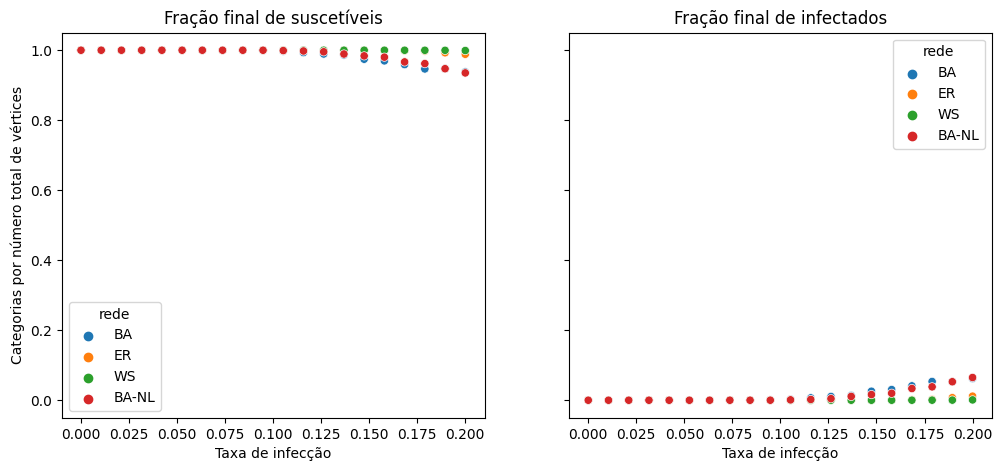

In [30]:
#Cria um gráfico de duas partes para visualizar as frações obtidas para cada uma das categorias ("S" e "I") do modelo.
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,5))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='beta', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de infecção')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='beta', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração final de infectados')
ax[1].set_xlabel('Taxa de infecção')

plt.show()

Podemos perceber dos gráficos acima que realmente há uma alteração nas frações de acordo com a alteração do grau médio da rede: quanto maior o valor dessa propriedade, mais facilmente a epidemia se propagará, o que faz sentido com a intuição que vértices mais conectados propagam epidemias mais facilmente.

Além disso, as redes sem escala são afetadas mais rapidamente que as outras, por conta da infecção de um hub afetar diretamente uma quantidade maior de vértices.

# Remoção de links - Falhas e ataques

## Visualização do método

In [15]:
#A simulação de ataque é feita ao remover o vértice mais conectado de acordo com o grau. Inicialmente,
#remove-se o vértice de grau mais alto, seguido pelo segundo mais conectado e assim por diante.

def ataque(H):
  G = H.copy()    #copia a rede para não modificar a entrada diretamente.
  N0 = len(G)
  vn = []
  S = []
  n = 0   #número de vértices removidos
  while(len(G.nodes()) > int(0.01*N0)):
    node = mais_conectado(G)  #seleciona o vértice mais conectado na maior componente
    G.remove_node(node)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)   #seleciona a maior componente...
    Glc = G.subgraph(Gcc[0])    #...e gera um gráfico a partir dela
    S.append(len(Glc)/N0)   #guarda o tamanho da maior componente.
    n = n + 1
    vn.append(n/N0)
  return S, vn

In [16]:
#Aplica a simulação de ataques em cada uma das topologias em estudo.
SER, vnER = ataque(ER_graph)   #Erdos-Reyni
SBA, vnBA = ataque(BA_graph)   #Barabási-Albert
SWS, vnWS = ataque(WS_graph)   #Watts-Strogatz
SBANL, vnBANL = ataque(BA_nl_graph)   #Barabási-Albert não-linear

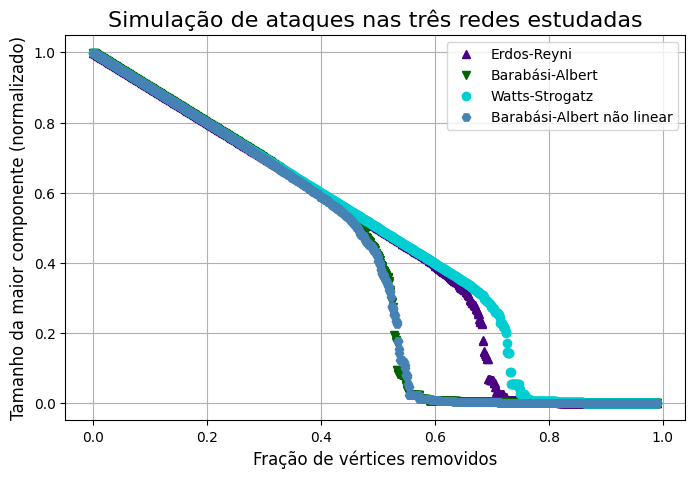

In [17]:
#Gera o gráfico de ataques para as topologias, com a maior componente vs fração de vértices removidos nos eixos vertical e horizontal, respectivamente.
plt.figure(figsize=(8,5))
plt.plot(vnER,SER, marker='^', color='indigo', linestyle='none', label='Erdos-Reyni')
plt.plot(vnBA,SBA, marker='v', color='darkgreen', linestyle='none', label='Barabási-Albert')
plt.plot(vnWS,SWS, marker='o', color='darkturquoise', linestyle='none', label='Watts-Strogatz')
plt.plot(vnBANL,SBANL, marker='H', color='steelblue', linestyle='none', label='Barabási-Albert não linear')
plt.legend()
plt.xlabel("Fração de vértices removidos", fontsize=12)
plt.ylabel("Tamanho da maior componente (normalizado)", fontsize=12)
plt.grid(True)
plt.title('Simulação de ataques nas três redes estudadas', fontsize=16)
plt.show()

Note que a rede Watts-Strogatz é mais lentamente afetada, com as topologias Barabási-Albert sendo as menos resilientes.

In [7]:
#Falhas são simuladas ao remover aleatoriamente um dado vértice da rede, diferentemente dos ataques onde
#a remoção é guiada por propriedades da rede (grau).

#O código é idêntico ao anterior com exceção da linha que define o vértice a ser removido.
def falhas(H):
  G = H.copy()
  N0 = len(G)
  vn = []
  S = []
  n = 0
  while(len(G.nodes()) > int(0.01*N0)):
    node = random.choice(list(G.nodes()))   #escolhe um vértice aleatório do grafo.
    G.remove_node(node)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    Glc = G.subgraph(Gcc[0])
    S.append(len(Glc)/N0)
    n = n + 1
    vn.append(n/N0)
  return S, vn

In [12]:
#Aplica a simulação de falhas em cada uma das topologias em estudo.
SER, vnER = falhas(ER_graph)
SBA, vnBA = falhas(BA_graph)
SWS, vnWS = falhas(WS_graph)
SBANL, vnBANL = falhas(BA_nl_graph)

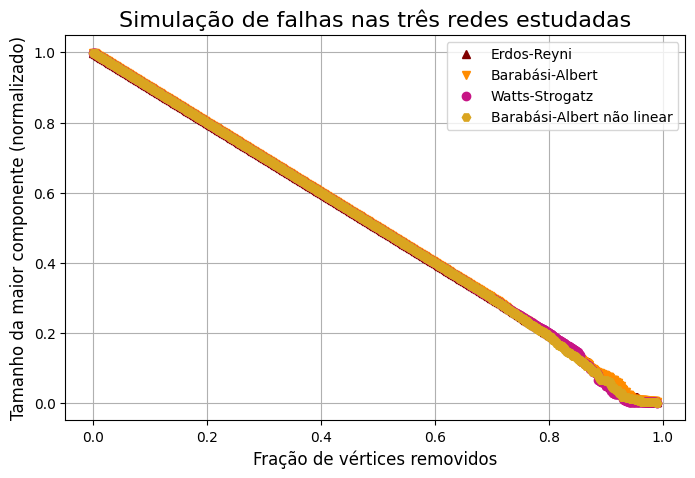

In [14]:
#Gera o gráfico de falhas para as topologias, com a maior componente vs fração de vértices removidos nos eixos vertical e horizontal, respectivamente.
plt.figure(figsize=(8,5))
plt.plot(vnER,SER, marker='^', color='maroon', linestyle='none', label='Erdos-Reyni')
plt.plot(vnBA,SBA, marker='v', color='darkorange', linestyle='none', label='Barabási-Albert')
plt.plot(vnWS,SWS, marker='o', color='mediumvioletred', linestyle='none', label='Watts-Strogatz')
plt.plot(vnBANL,SBANL, marker='H', color='goldenrod', linestyle='none', label='Barabási-Albert não linear')
plt.legend()
plt.xlabel("Fração de vértices removidos", fontsize=12)
plt.ylabel("Tamanho da maior componente (normalizado)", fontsize=12)
plt.grid(True)
plt.title('Simulação de falhas nas três redes estudadas', fontsize=16)
plt.show()

Dado que as redes não diferem muito em termos de remoções de links por falhas, vamos implementar o efeito de ataques nas redes e, a partir disso, propagar a epidemia.

## Ataques e o modelo SIR

In [ ]:
#Vamos aproveitar partes do código de ataques como base para aplicar a epidemia, e
#-> incluir partes do código da função que roda a simulação SIR.

def SIR_com_ataques(H, beta, mu, max_removidos):
  '''
  Esta função aplicará uma simulação tipo Gillespie do modelo SIR cada vez que um vértice for removido.
  -> H: a rede a ser usada. nx.Graph()
  -> beta: valor único, float.
  -> mu: taxa de recuperação dos vértices. Valor único.
  -> max_removidos: porcentagem limite de remoção de vértices.
  '''
  G = H.copy()    #faz uma cópia da rede para não alterá-la diretamente.
  N0 = len(G)
  vn = []
  S = []
  n = 0           #número de vértices removidos
  df_res = pd.DataFrame()

  while(len(G.nodes()) > int((1-max_removidos)*N0)):
    node = mais_conectado(G)  #seleciona o vértice mais conectado na maior componente
    G.remove_node(node)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    Glc = G.subgraph(Gcc[0])
    S.append(len(Glc)/N0)     #guarda o tamanho da maior componente.
    n = n + 1
    print('Vértices removidos:', n)
    vn.append(n/N0)

    #Roda o modelo SIR na rede G com o vértice 'node' removido
    final_S_all_nodes = []
    final_I_all_nodes = []
    final_R_all_nodes = []
    S_aux = []
    I_aux = []
    R_aux = []
    for node in G.nodes():
      vt, vS, vI, vR = EoN.Gillespie_SIR(G, beta, mu, initial_infecteds = node)
      S_aux.append( vS[len(vS)-1] )
      I_aux.append( max(vI) )       #Aqui, queremos o pico de infectados ao invés do valor final.
      R_aux.append( vR[len(vR)-1] )

    final_S_all_nodes.append( np.mean(S_aux)/len(G.nodes()) )
    final_I_all_nodes.append( np.mean(I_aux)/len(G.nodes()) )
    final_R_all_nodes.append( np.mean(R_aux)/len(G.nodes()) )

    #Gera o dataframe resultante:
    data_epi = {'beta': beta, 'fracao_suscetiveis': final_S_all_nodes, 'fracao_infectados': final_I_all_nodes, 'fracao_recuperados': final_R_all_nodes}
    df_aux = pd.DataFrame(data=data_epi)
    df_res = pd.concat([df_res, df_aux])

  df_res['maior_componente'] = S
  df_res['vertices_removidos'] = vn

  return df_res

In [ ]:
#Roda a função acima para as quatro redes
beta = 0.5    #fixo, pois queremos apenas estudar o efeito da remoção dos vértices, sem alterar a epidemia.
mu = 1
max_removidos = 0.9     #removerá até max_removidos*100% dos vértices. Aqui, 90%
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']
df_res = pd.DataFrame()

for n in range(len(todas_redes)):
  print('---> Rede:', net_nomes[n])
  aux = SIR_com_ataques(todas_redes[n], beta, mu, max_removidos)
  aux['rede'] = np.tile(net_nomes[n], int(len(todas_redes[n])*max_removidos)+1)
  df_res = pd.concat([df_res, aux])

df_res.to_csv('processos_epi_SIR_ataques_1000N.csv')

#Tempo de simulação: ~1h40m

---> Rede: BA
Vértices removidos: 1
Vértices removidos: 2
Vértices removidos: 3
Vértices removidos: 4
Vértices removidos: 5
Vértices removidos: 6
Vértices removidos: 7
Vértices removidos: 8
Vértices removidos: 9
Vértices removidos: 10
Vértices removidos: 11
Vértices removidos: 12
Vértices removidos: 13
Vértices removidos: 14
Vértices removidos: 15
Vértices removidos: 16
Vértices removidos: 17
Vértices removidos: 18
Vértices removidos: 19
Vértices removidos: 20
Vértices removidos: 21
Vértices removidos: 22
Vértices removidos: 23
Vértices removidos: 24
Vértices removidos: 25
Vértices removidos: 26
Vértices removidos: 27
Vértices removidos: 28
Vértices removidos: 29
Vértices removidos: 30
Vértices removidos: 31
Vértices removidos: 32
Vértices removidos: 33
Vértices removidos: 34
Vértices removidos: 35
Vértices removidos: 36
Vértices removidos: 37
Vértices removidos: 38
Vértices removidos: 39
Vértices removidos: 40
Vértices removidos: 41
Vértices removidos: 42
Vértices removidos: 43
Vértic

### Figuras

Aqui utilizaremos `lineplot()` ao invés de `scatterplot()` por conta da densidade de pontos.

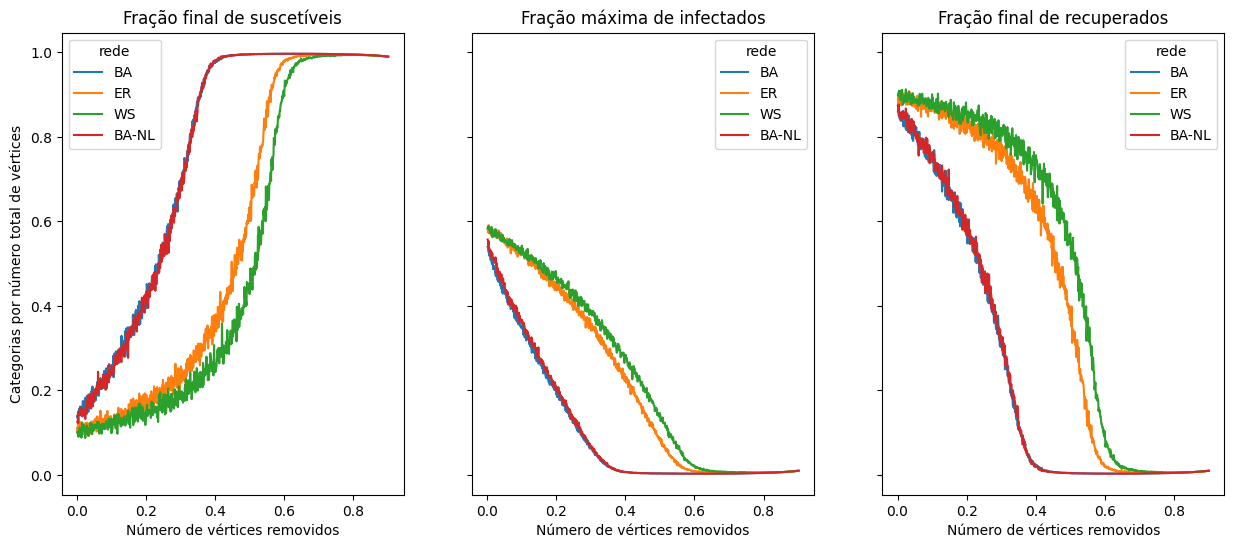

In [22]:
#Cria um gráfico de três partes para visualizar as frações obtidas para cada uma das categorias ("S", "I" e "R") do modelo,
#-> com o número de vértices removidos no eixo horizontal.
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,6))

#Parte 1: Fração de suscetíveis
sns.lineplot(x='vertices_removidos', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Número de vértices removidos')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.lineplot(x='vertices_removidos', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração máxima de infectados')
ax[1].set_xlabel('Número de vértices removidos')

#Parte 3: Fração de recuperados
sns.lineplot(x='vertices_removidos', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Número de vértices removidos')

plt.show()

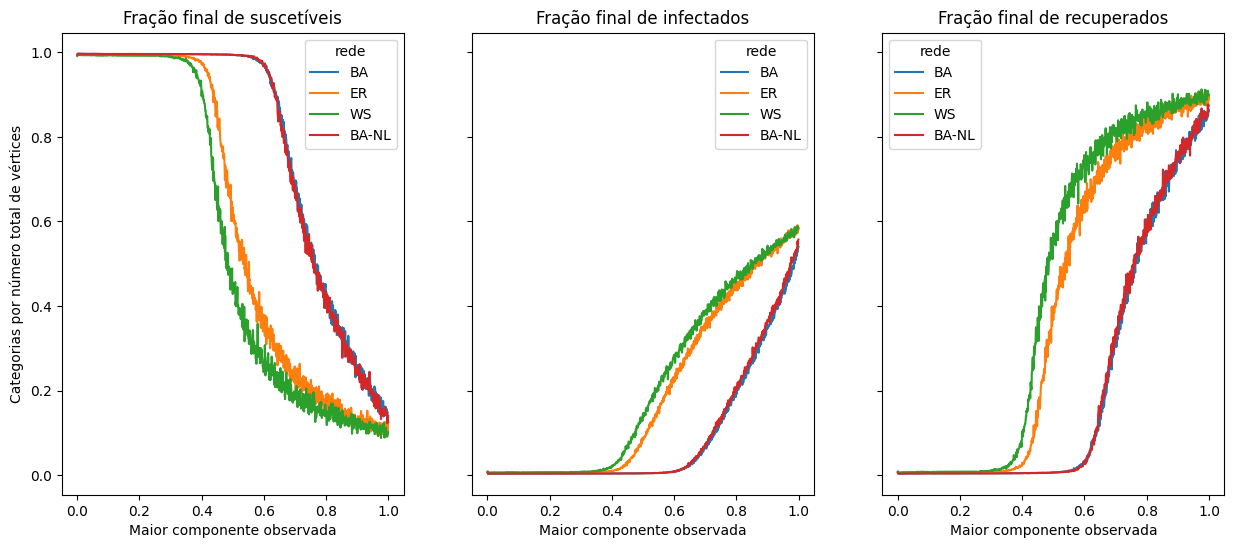

In [ ]:
#Cria um gráfico de três partes para visualizar as frações obtidas para cada uma das categorias ("S", "I" e "R") do modelo,
#-> com o tamanho da maior componente observada para cada passo de remoção de vértices no eixo horizontal.
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,6))

#Parte 1: Fração de suscetíveis
sns.lineplot(x='maior_componente', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Maior componente observada')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.lineplot(x='maior_componente', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração final de infectados')
ax[1].set_xlabel('Maior componente observada')

#Parte 3: Fração de recuperados
sns.lineplot(x='maior_componente', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Maior componente observada')

plt.show()

## Comparação com a percolação da rede

Podemos também verificar como a taxa de infecção se comporta conforme alteramos o tamanho da rede por percolação. Vamos utilizar somente a topologia Erdos-Reyni como exemplo, de forma a reproduzir a figura 6.7 de [1]

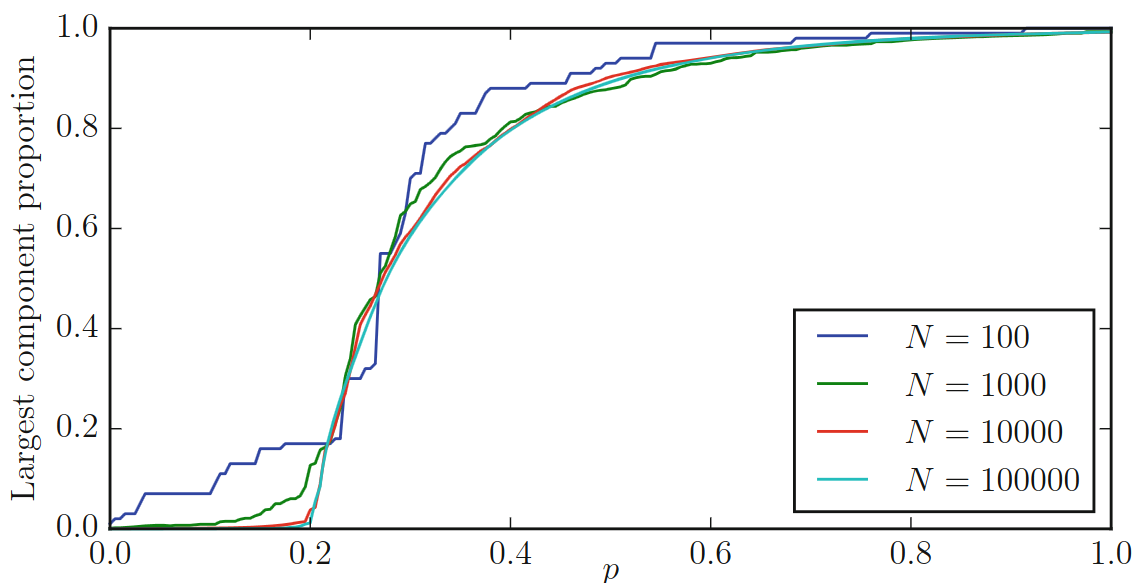

[1] https://link.springer.com/book/10.1007/978-3-319-50806-1, Fig. 6.7.

In [26]:
#Novas redes para os testes de percolação
#-> 100 vértices, grau médio 5.
p_ER = 0.055
ER_graph_100 = nx.gnp_random_graph(100, p_ER, seed=42, directed=False)
ER_graph_100.remove_edges_from(nx.selfloop_edges(ER_graph_100))

print('Erdos-Reyni, 100 vértices:', "%3.1f"%momento(ER_graph_100,1))

Erdos-Reyni, 100 vértices: 5.0


In [ ]:
#-> 1000 vértices, grau médio 5.
p_ER = 0.005
ER_graph_1000 = nx.gnp_random_graph(1000, p_ER, seed=42, directed=False)
ER_graph_1000.remove_edges_from(nx.selfloop_edges(ER_graph_100))

print('Erdos-Reyni, 1000 vértices:', "%3.1f"%momento(ER_graph_1000,1))

Erdos-Reyni, 1000 vértices: 5.0


In [ ]:
#-> 10000 vértices, grau médio 5.
p_ER = 0.0005
ER_graph_10000 = nx.gnp_random_graph(10000, p_ER, seed=42, directed=False)
ER_graph_10000.remove_edges_from(nx.selfloop_edges(ER_graph_10000))

print('Erdos-Reyni, 10000 vértices:', "%3.1f"%momento(ER_graph_10000,1))

Erdos-Reyni, 10000 vértices: 5.0


In [ ]:
def estima_prob_infeccao_SIR(G, p_mantidos):
  H = EoN.percolate_network(G, p_mantidos)   #aplica a percolação, com p_mantidos sendo a fração de vértices mantidos
  tamanho = max((len(CC) for CC in nx.connected_components(H)))    #pega a maior componente
  prob = float(tamanho)/G.order()    #retorna a probalilidade de infeçcão.

  return prob

<Axes: xlabel='beta', ylabel='maior_componente'>

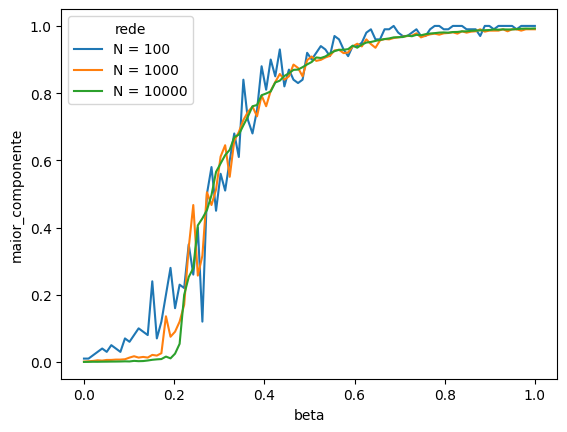

In [ ]:
#Executa a função acima para as três redes Erdos-Reyni de tamanhos diferentes.
df_res = pd.DataFrame()
todas_redes = [ER_graph_100, ER_graph_1000, ER_graph_10000]
tamanho_redes = ['N = 100', 'N = 1000', 'N = 10000']
betas = np.linspace(0, 1, 100)

for n in range(len(todas_redes)):
  probs = []
  for beta in betas:
    probs.append(estima_prob_infeccao_SIR(todas_redes[n], beta))
  aux_data = {'beta': betas, 'maior_componente': probs, 'rede': np.tile(tamanho_redes[n], len(betas))}
  aux = pd.DataFrame(aux_data)
  df_res = pd.concat([df_res, aux])

sns.lineplot(x='beta', y='maior_componente', hue='rede', data=df_res)

Do gráfico acima, nota-se que a curva se torna cada vez mais suave conforme N aumenta.

# Vacinação - Modelo SIR+V

## Exemplo

In [44]:
#Seleciona a rede a ser usada. Como exemplo, tomamos a rede Barabási-Albert de 1000 vértices.
G = BA_graph
N = len(BA_graph)
seed = 42

#Os vértices irão variar a taxa de saída da classe exposta, enquanto as arestas mudarão a taxa de transmissão.
#-> não há variação na taxa de recuperação, como nos outros casos.
#Esses atributos serão utilizados para definir as taxas de transmissão. Os nomes dos
#-> mesmos serão definidos em H e J.

random.seed(seed)
node_attribute_dict = {node: 0.5+random.random() for node in G.nodes()}
nx.set_node_attributes(G, values=node_attribute_dict, name='sus2vacc_weight')

edge_attribute_dict = {edge: 0.5+random.random() for edge in G.edges()}
nx.set_edge_attributes(G, values=edge_attribute_dict, name='transmission_weight')

#Taxas de transição:
r_SV = 0.5    #suscetível -> vacinado
r_IR = 1.0    #infectado -> recuperado, =mu
r_SI = 0.5    #suscetível -> infectado, =beta

H = nx.DiGraph()    #cria um novo grafo
#faz as taxas entrarem como pesos nas arestas do grafo.
H.add_edge('S', 'V', rate = r_SV, weight_label='sus2vacc_weight')
H.add_edge('I', 'R', rate = r_IR)

J = nx.DiGraph()
#faz a taxa de infecção entrar como peso nas arestas do grafo
#-> é necessário utilizar dois grafos distintos, H e J, por conta da estrutura da função
#-> Gillespie_simple_contagion()
J.add_edge(('I', 'S'), ('I', 'I'), rate = r_SI, weight_label='transmission_weight')

#Vértices infectados no tempo inicial t0
inf_nodes = range(10)

#infecta os primeiros 10 vértices:
IC = defaultdict(lambda: 'S')
for node in inf_nodes:
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R', 'V')    #rotula as categorias.

#Aplica a epidemia.
t, S, I, R, V = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses,
                                        tmax = 50)

In [45]:
#normaliza os valores para termos frações.
vS = [valores/N for valores in S]
vI = [valores/N for valores in I]
vR = [valores/N for valores in R]
vV = [valores/N for valores in V]

#E cria o respectivo dataframe.
data_lists = {'suscetiveis': vS, 'infectados': vI, 'recuperados': vR, 'vacinados': vV, 'tempo': t}
df_SIRV = pd.DataFrame(data=data_lists)

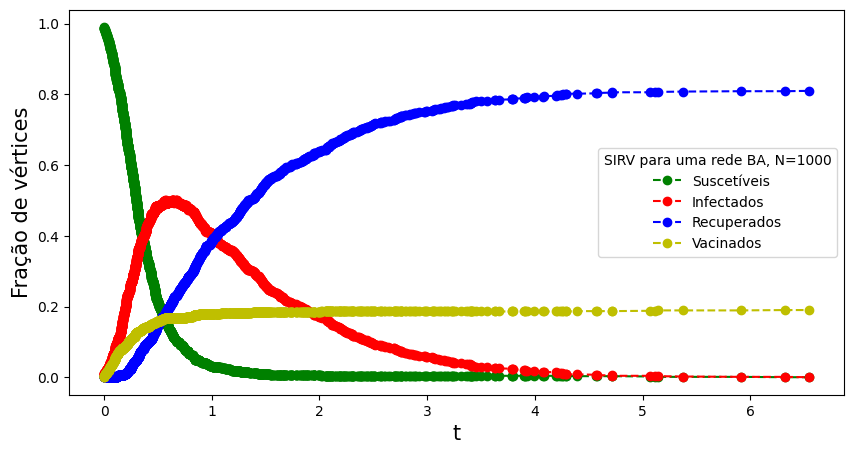

In [46]:
#Mostra o resultado da simulação anterior

plt.figure(figsize=(10,5))
plt.plot(t, vS, 'go--', label='Suscetíveis')
plt.plot(t, vI, 'ro--', label='Infectados')
plt.plot(t, vR, 'bo--', label='Recuperados')
plt.plot(t, vV, 'yo--', label='Vacinados')
plt.xlabel("t", fontsize=15)
plt.ylabel("Fração de vértices", fontsize=15)
plt.legend(title='SIRV para uma rede BA, N=1000')
plt.show()

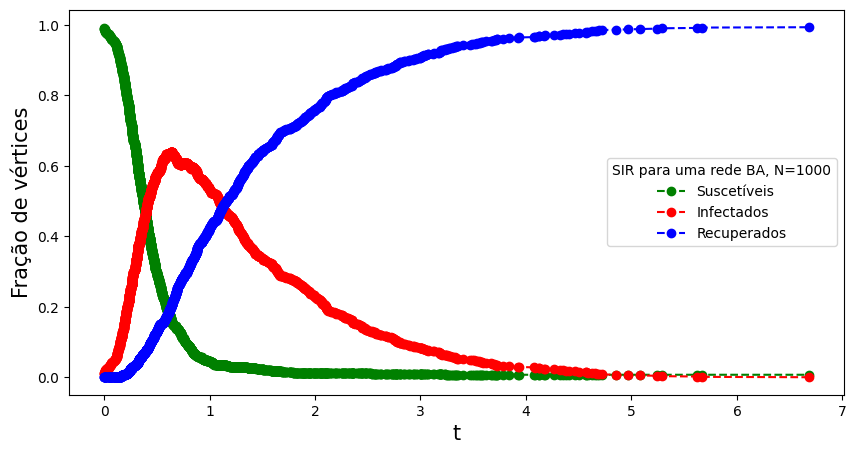

In [43]:
#Comparando com uma epidemia simples SIR:
beta = 0.5
mu = 1
vt, vS, vI, vR = EoN.Gillespie_SIR(BA_graph, beta, mu, initial_infecteds = range(10))   #aplica a epidemia
#normaliza os valores para termos frações.
vS = [valores/N for valores in vS]
vI = [valores/N for valores in vI]
vR = [valores/N for valores in vR]

#Faz o gráfico.
plt.figure(figsize=(10,5))
plt.plot(vt, vS, 'go--', label='Suscetíveis')
plt.plot(vt, vI, 'ro--', label='Infectados')
plt.plot(vt, vR, 'bo--', label='Recuperados')
plt.xlabel("t", fontsize=15)
plt.ylabel("Fração de vértices", fontsize=15)
plt.legend(title='SIR para uma rede BA, N=1000')

Note que a taxa de recuperados será condicionada com o número de vacinados, ou seja: S+I+R+V = 1.

## Modelagem

In [ ]:
def simula_SIRV(rede, mu, tipo, parametros, seed):
  '''
  Simula uma epidemia SIR+V, podendo variar tanto a taxa de infecção (mantendo a taxa de vacinação constante),
  -> ou vice-versa.

  -> rede: a rede a ser usada. A entrada esperada é nx.Graph().
  -> mu: taxa de recuperação dos vértices. Valor único.
  -> tipo: forma que o teste deverá ser executado. Deve ser 'tax_infeccao' ou 'tax_vacinacao'
  -> parâmetros: lista de listas. A primeira entrada deverá ser a lista que será iterada, por
  --> exemplo contendo todos as taxas de infecção beta; e a segunda será o parâmetro a ser mantido constante.
  --> No exemplo de variarmos a taxa de infeçcão, a taxa de vacinação será constante.
  -> seed: semente aleatória para o método random().

  '''

  G = rede.copy()
  random.seed(seed)
  #Inicializa os vetores que guardarão os resultados finais, e o contador das taxas de infecção.
  final_S_todos_vertices = []
  final_I_todos_vertices = []
  final_R_todos_vertices = []
  final_V_todos_vertices = []
  counter_beta = 1

  #Os vértices irão variar a taxa de saída da classe exposta, enquanto as arestas mudarão a taxa de transmissão.
  #-> não há variação na taxa de recuperação, como nos outros casos.
  #Esses atributos serão utilizados para definir as taxas de transmissão. Os nomes dos
  #-> mesmos serão definidos em H e J.
  node_attribute_dict = {node: 0.5+random.random() for node in G.nodes()}
  nx.set_node_attributes(G, values=node_attribute_dict, name='sus2vacc_weight')

  edge_attribute_dict = {edge: 0.5+random.random() for edge in G.edges()}
  nx.set_edge_attributes(G, values=edge_attribute_dict, name='transmission_weight')

  #Taxas de transição:
  r_IR = mu   #infectado -> recuperado, =mu

  for param in parametros[0]:
    S_aux = []
    I_aux = []
    R_aux = []
    V_aux = []

    #Configura as taxas de acordo com o método escolhido:
    if(tipo == 'tax_infeccao'):
      r_SV = parametros[1]        #taxa de vacinação
      r_SI = param                #taxa de infecção
      nome = 'Taxa de infecção'
    if(tipo == 'tax_vacinacao'):
      r_SI = parametros[1]        #taxa de infecção
      r_SV = param                #taxa de vacinação
      nome = 'Taxa de vacinação'

    print(nome, round(param,2), '(', counter_beta, '/', len(parametros[0]), ')' )

    H = nx.DiGraph()      #cria um novo grafo
    #faz as taxas entrarem como pesos nas arestas do grafo.
    H.add_edge('S', 'V', rate = r_SV, weight_label='sus2vacc_weight')
    H.add_edge('I', 'R', rate = r_IR)   #a transição aqui não dependerá de pesos.

    J = nx.DiGraph()
    #faz a taxa de infecção entrar como peso nas arestas do grafo
    #-> é necessário utilizar dois grafos distintos, H e J, por conta da estrutura da função
    #-> Gillespie_simple_contagion()
    J.add_edge(('I', 'S'), ('I', 'I'), rate = r_SI, weight_label='transmission_weight')

    for node in rede.nodes():
      #Infecta vértice a vertice e propaga a epidemia.
      IC = defaultdict(lambda: 'S')
      IC[node] = 'I'
      return_statuses = ('S', 'I', 'R', 'V')

      #Aplica a epidemia.
      vt, vS, vI, vR, vV = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses,
                                              tmax = 50)
      S_aux.append( vS[len(vS)-1] )
      I_aux.append( max(vI) )   #Aqui, queremos o pico de infectados ao invés do valor final.
      R_aux.append( vR[len(vR)-1] )
      V_aux.append( vV[len(vV)-1] )

    final_S_todos_vertices.append( np.mean(S_aux)/len(rede.nodes()) )
    final_I_todos_vertices.append( np.mean(I_aux)/len(rede.nodes()) )
    final_R_todos_vertices.append( np.mean(R_aux)/len(rede.nodes()) )
    final_V_todos_vertices.append( np.mean(V_aux)/len(rede.nodes()) )
    counter_beta = counter_beta +1

  #Gera o dataframe resultante de acordo com o método escolhido:
  if(tipo == 'tax_infeccao'):
    data_epi = {'beta': parametros[0], 'tax_vacinacao': np.tile(parametros[1], len(parametros[0])),
                'fracao_suscetiveis': final_S_todos_vertices, 'fracao_infectados': final_I_todos_vertices,
                'fracao_recuperados': final_R_todos_vertices, 'fracao_vacinados': final_V_todos_vertices}

  if(tipo == 'tax_vacinacao'):
    data_epi = {'beta': np.tile(parametros[1], len(parametros[0])), 'tax_vacinacao': parametros[0],
                'fracao_suscetiveis': final_S_todos_vertices, 'fracao_infectados': final_I_todos_vertices,
                'fracao_recuperados': final_R_todos_vertices, 'fracao_vacinados': final_V_todos_vertices}

  df = pd.DataFrame(data=data_epi)

  return df

A modelagem abaixo considera a taxa de vacinação constante em 0.5, enquanto varia a taxa de infecção.

In [ ]:
#Roda a função acima para as quatro redes
mu = 1
#50% da população sucetível tomará a vacina.
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']
tipo = 'tax_infeccao'
parametros = [np.linspace(0, 1, 50), 0.5]   #beta de 0 a 1 em 50 passos constantes, tax_vac = 0.5
df_res = pd.DataFrame()

for n in range(len(todas_redes)):
  print('---> Rede:', net_nomes[n])
  aux = simula_SIRV(todas_redes[n], mu, tipo, parametros, seed=42)
  aux['rede'] = np.tile(net_nomes[n], len(parametros[0]))

  df_res = pd.concat([df_res, aux])

df_res.to_csv('processos_epi_SIRV_fracoes-vs-beta_1000N.csv')

#Tempo de execução: ~2h30m

---> Rede: BA
Taxa de infecção 0.0 ( 1 / 50 )
Taxa de infecção 0.02 ( 2 / 50 )
Taxa de infecção 0.04 ( 3 / 50 )
Taxa de infecção 0.06 ( 4 / 50 )
Taxa de infecção 0.08 ( 5 / 50 )
Taxa de infecção 0.1 ( 6 / 50 )
Taxa de infecção 0.12 ( 7 / 50 )
Taxa de infecção 0.14 ( 8 / 50 )
Taxa de infecção 0.16 ( 9 / 50 )
Taxa de infecção 0.18 ( 10 / 50 )
Taxa de infecção 0.2 ( 11 / 50 )
Taxa de infecção 0.22 ( 12 / 50 )
Taxa de infecção 0.24 ( 13 / 50 )
Taxa de infecção 0.27 ( 14 / 50 )
Taxa de infecção 0.29 ( 15 / 50 )
Taxa de infecção 0.31 ( 16 / 50 )
Taxa de infecção 0.33 ( 17 / 50 )
Taxa de infecção 0.35 ( 18 / 50 )
Taxa de infecção 0.37 ( 19 / 50 )
Taxa de infecção 0.39 ( 20 / 50 )
Taxa de infecção 0.41 ( 21 / 50 )
Taxa de infecção 0.43 ( 22 / 50 )
Taxa de infecção 0.45 ( 23 / 50 )
Taxa de infecção 0.47 ( 24 / 50 )
Taxa de infecção 0.49 ( 25 / 50 )
Taxa de infecção 0.51 ( 26 / 50 )
Taxa de infecção 0.53 ( 27 / 50 )
Taxa de infecção 0.55 ( 28 / 50 )
Taxa de infecção 0.57 ( 29 / 50 )
Taxa de infe

Na célula abaixo, faz a simulação reversa: mantém a taxa de infecção constante enquanto varia a de vacinação.

In [ ]:
#Roda a função acima para as quatro redes
mu = 1
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']
tipo = 'tax_vacinacao'
parametros = [np.linspace(0, 1, 50), 0.5]   #tax_vac de 0 a 1 em 50 passos constantes, beta = 0.5
df_res = pd.DataFrame()

for n in range(len(todas_redes)):
  print('---> Rede:', net_nomes[n])
  aux = simula_SIRV(todas_redes[n], mu, tipo, parametros, seed=42)
  aux['rede'] = np.tile(net_nomes[n], len(parametros[0]))

  df_res = pd.concat([df_res, aux])

df_res.to_csv('processos_epi_SIRV_fracoes-vs-tax_vac_1000N.csv')

#Tempo de execução: ~2h30min.

---> Rede: BA
Taxa de vacinação 0.0 ( 1 / 50 )
Taxa de vacinação 0.02 ( 2 / 50 )
Taxa de vacinação 0.04 ( 3 / 50 )
Taxa de vacinação 0.06 ( 4 / 50 )
Taxa de vacinação 0.08 ( 5 / 50 )
Taxa de vacinação 0.1 ( 6 / 50 )
Taxa de vacinação 0.12 ( 7 / 50 )
Taxa de vacinação 0.14 ( 8 / 50 )
Taxa de vacinação 0.16 ( 9 / 50 )
Taxa de vacinação 0.18 ( 10 / 50 )
Taxa de vacinação 0.2 ( 11 / 50 )
Taxa de vacinação 0.22 ( 12 / 50 )
Taxa de vacinação 0.24 ( 13 / 50 )
Taxa de vacinação 0.27 ( 14 / 50 )
Taxa de vacinação 0.29 ( 15 / 50 )
Taxa de vacinação 0.31 ( 16 / 50 )
Taxa de vacinação 0.33 ( 17 / 50 )
Taxa de vacinação 0.35 ( 18 / 50 )
Taxa de vacinação 0.37 ( 19 / 50 )
Taxa de vacinação 0.39 ( 20 / 50 )
Taxa de vacinação 0.41 ( 21 / 50 )
Taxa de vacinação 0.43 ( 22 / 50 )
Taxa de vacinação 0.45 ( 23 / 50 )
Taxa de vacinação 0.47 ( 24 / 50 )
Taxa de vacinação 0.49 ( 25 / 50 )
Taxa de vacinação 0.51 ( 26 / 50 )
Taxa de vacinação 0.53 ( 27 / 50 )
Taxa de vacinação 0.55 ( 28 / 50 )
Taxa de vacinação 

### Figuras

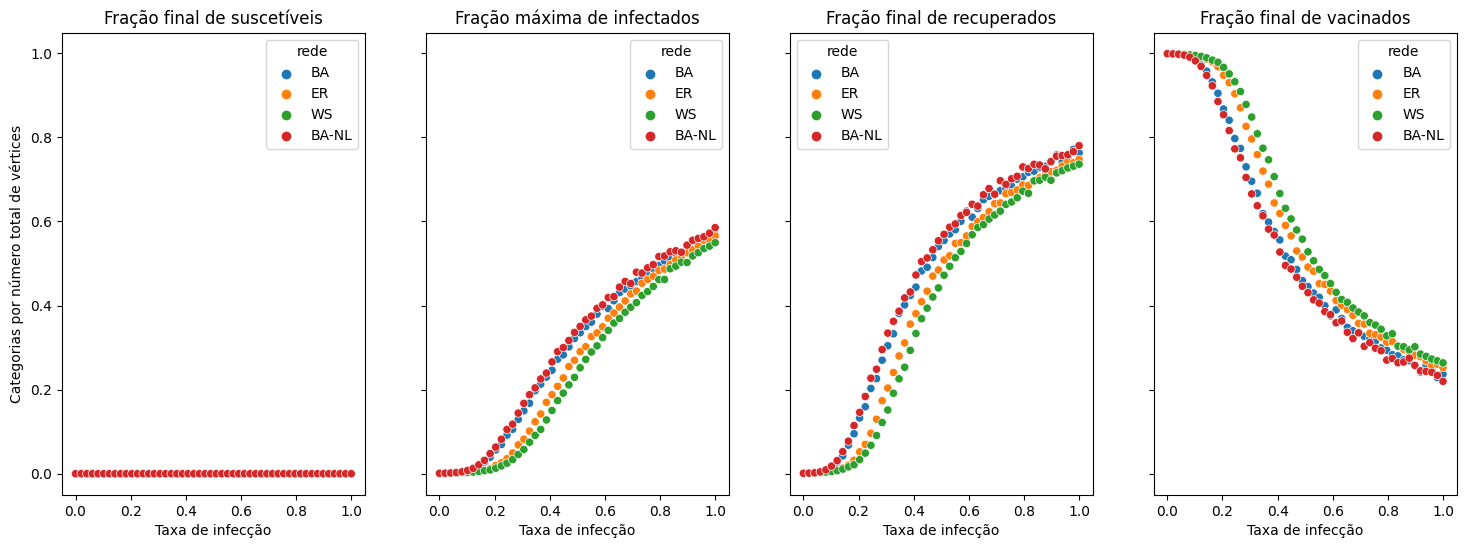

In [ ]:
#Cria um gráfico de quatro partes para visualizar as frações obtidas para cada uma das categorias ("S", "I", "R" e "V") do modelo.
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(18,6))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='beta', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de infecção')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='beta', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração máxima de infectados')
ax[1].set_xlabel('Taxa de infecção')

#Parte 3: Fração de recuperados
sns.scatterplot(x='beta', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Taxa de infecção')

#Parte 4: Fração de vacinados
sns.scatterplot(x='beta', y='fracao_vacinados', hue='rede', data=df_res, ax=ax[3])
ax[3].set_title('Fração final de vacinados')
ax[3].set_xlabel('Taxa de infecção')

plt.show()

Nesse caso, a fração de suscetíveis é zero porque, ao final da simulação, não sobram vértices que não tenham tido contato com a epidemia e se infectado ou recuperado, ou que não tenham sido vacinados.

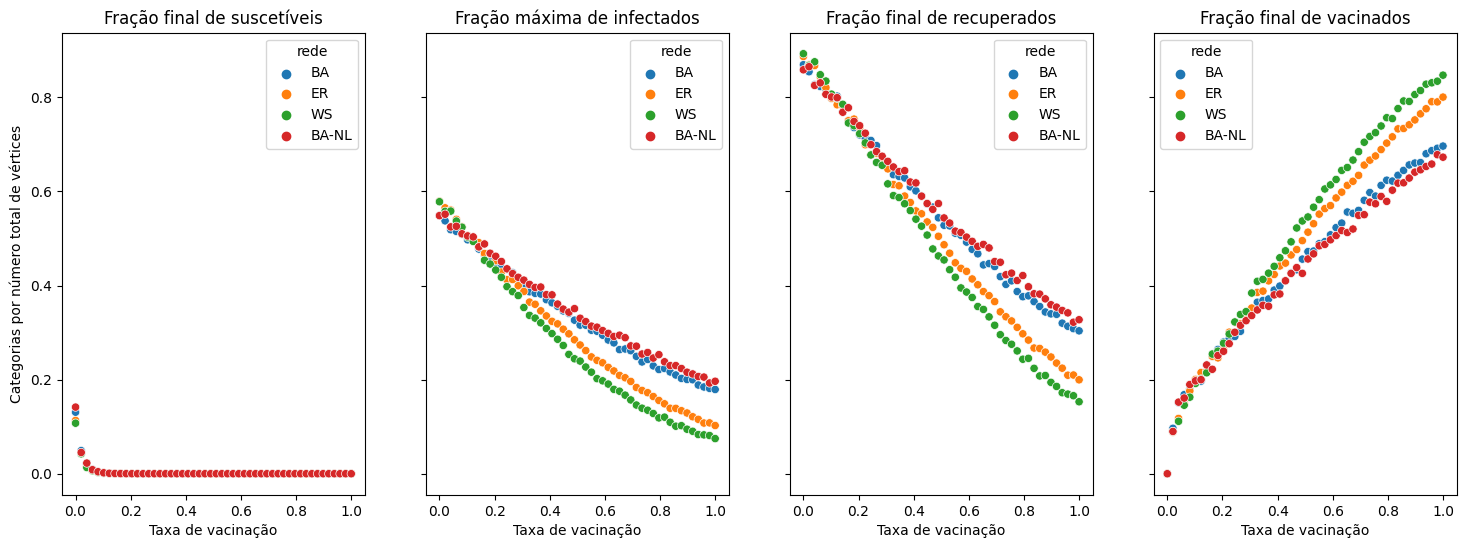

In [36]:
#Frações para cada categoria epidemiológica vs taxa de vacinação
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(18,6))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='tax_vacinacao', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de vacinação')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='tax_vacinacao', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração máxima de infectados')
ax[1].set_xlabel('Taxa de vacinação')

#Parte 3: Fração de recuperados
sns.scatterplot(x='tax_vacinacao', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Taxa de vacinação')

#Parte 4: Fração de vacinados
sns.scatterplot(x='tax_vacinacao', y='fracao_vacinados', hue='rede', data=df_res, ax=ax[3])
ax[3].set_title('Fração final de vacinados')
ax[3].set_xlabel('Taxa de vacinação')

plt.show()

A mesma coisa ocorre com a fração de suscetíveis nesse caso, mas a transição não é instantânea como no uso da taxa de infecção.

Note que tanto a fração máxima de infectados quanto a de final de recuperados é visivelmente afetada pela proteção da vacina aplicada na rede.

# Caso não-Markoviano

In [ ]:
def simula_SIR_nonmarkoviano(rede, betas, rec_time):
  '''
  Esta função aplicará uma simulação não markoviana do modelo SIR de acordo com os valores de taxa de infecção
  -> e do tempo de recuperação.

  -> rede: a rede a ser usada. A entrada esperada é nx.Graph().
  -> betas: lista com os valores de beta, ou taxa de transmissão, para rodar a simulação.
  -> rec_time: taxa de recuperação dos vértices. Valor único.
  '''

  def trans_time_fxn(source, target, rate):
    '''
    Define o tempo de transmissão fixo baseado na função de distribuição de probabilidade (fdp) exponencial.
    -> source: vértice origem;
    -> target: vértice objetivo;
    -> rate: taxa de transmissão.
    '''
    return random.expovariate(rate)   #escolhe um número aleatório da fdp.

  def rec_time_fxn(node,D):
    '''
    Define o tempo de recuperação de um vértice 'node' baseado no valor de 'rec_time' (=D)
    '''
    return D

  final_S_todos_vertices = []
  final_I_todos_vertices = []
  final_R_todos_vertices = []
  counter_beta = 1

  #Mesma estrutura da simulação SIR markoviana, com a diferença estando na função chamada
  #-> e seus parâmetros.
  for beta in betas:
    print('Beta:', round(beta,2), '(', counter_beta, '/', len(betas), ')' )
    S_aux = []
    I_aux = []
    R_aux = []
    for node in rede.nodes():
      vt, vS, vI, vR = EoN.fast_nonMarkov_SIR(rede, trans_time_fxn=trans_time_fxn,
                                              rec_time_fxn=rec_time_fxn, trans_time_args=(beta,),
                                              rec_time_args=(rec_time,), initial_infecteds = node)
      S_aux.append( vS[len(vS)-1] )
      I_aux.append( max(vI) )
      R_aux.append( vR[len(vR)-1] )

    final_S_todos_vertices.append( np.mean(S_aux)/len(rede.nodes()) )
    final_I_todos_vertices.append( np.mean(I_aux)/len(rede.nodes()) )
    final_R_todos_vertices.append( np.mean(R_aux)/len(rede.nodes()) )
    counter_beta = counter_beta +1

  #Gera o dataframe resultante:
  data_epi = {'beta': betas, 'fracao_suscetiveis': final_S_todos_vertices,
              'fracao_infectados': final_I_todos_vertices, 'fracao_recuperados': final_R_todos_vertices}
  df = pd.DataFrame(data=data_epi)

  return df

In [ ]:
#Roda a função acima para as quatro redes
#-> parâmetros para a simulação: mesmos da simulação SIR Markoviana.
betas = np.linspace(0, 1, 50)
rec_time = 1
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']
df_res = pd.DataFrame()

for n in range(len(todas_redes)):
  print('---> Rede:', net_nomes[n])
  aux = simula_SIR_nonmarkoviano(todas_redes[n], betas, rec_time)
  aux['rede'] = np.tile(net_nomes[n], len(betas))

  df_res = pd.concat([df_res, aux])

df_res.to_csv('processos_epi_SIR_nonmarkov.csv')

#Obs: tempo total de simulação: 36 min
#Obs 2: os vértices com erro "RuntimeWarning: divide by zero (...)" não são adicionados no resultado final.

---> Rede: BA
Beta: 0.0 ( 1 / 50 )
Beta: 0.02 ( 2 / 50 )
Beta: 0.04 ( 3 / 50 )


/usr/lib/python3.11/random.py:628: RuntimeWarning: divide by zero encountered in scalar divide
  return -_log(1.0 - self.random()) / lambd


Beta: 0.06 ( 4 / 50 )
Beta: 0.08 ( 5 / 50 )
Beta: 0.1 ( 6 / 50 )
Beta: 0.12 ( 7 / 50 )
Beta: 0.14 ( 8 / 50 )
Beta: 0.16 ( 9 / 50 )
Beta: 0.18 ( 10 / 50 )
Beta: 0.2 ( 11 / 50 )
Beta: 0.22 ( 12 / 50 )
Beta: 0.24 ( 13 / 50 )
Beta: 0.27 ( 14 / 50 )
Beta: 0.29 ( 15 / 50 )
Beta: 0.31 ( 16 / 50 )
Beta: 0.33 ( 17 / 50 )
Beta: 0.35 ( 18 / 50 )
Beta: 0.37 ( 19 / 50 )
Beta: 0.39 ( 20 / 50 )
Beta: 0.41 ( 21 / 50 )
Beta: 0.43 ( 22 / 50 )
Beta: 0.45 ( 23 / 50 )
Beta: 0.47 ( 24 / 50 )
Beta: 0.49 ( 25 / 50 )
Beta: 0.51 ( 26 / 50 )
Beta: 0.53 ( 27 / 50 )
Beta: 0.55 ( 28 / 50 )
Beta: 0.57 ( 29 / 50 )
Beta: 0.59 ( 30 / 50 )
Beta: 0.61 ( 31 / 50 )
Beta: 0.63 ( 32 / 50 )
Beta: 0.65 ( 33 / 50 )
Beta: 0.67 ( 34 / 50 )
Beta: 0.69 ( 35 / 50 )
Beta: 0.71 ( 36 / 50 )
Beta: 0.73 ( 37 / 50 )
Beta: 0.76 ( 38 / 50 )
Beta: 0.78 ( 39 / 50 )
Beta: 0.8 ( 40 / 50 )
Beta: 0.82 ( 41 / 50 )
Beta: 0.84 ( 42 / 50 )
Beta: 0.86 ( 43 / 50 )
Beta: 0.88 ( 44 / 50 )
Beta: 0.9 ( 45 / 50 )
Beta: 0.92 ( 46 / 50 )
Beta: 0.94 ( 47 / 50 

/usr/lib/python3.11/random.py:628: RuntimeWarning: divide by zero encountered in scalar divide
  return -_log(1.0 - self.random()) / lambd


Beta: 0.06 ( 4 / 50 )
Beta: 0.08 ( 5 / 50 )
Beta: 0.1 ( 6 / 50 )
Beta: 0.12 ( 7 / 50 )
Beta: 0.14 ( 8 / 50 )
Beta: 0.16 ( 9 / 50 )
Beta: 0.18 ( 10 / 50 )
Beta: 0.2 ( 11 / 50 )
Beta: 0.22 ( 12 / 50 )
Beta: 0.24 ( 13 / 50 )
Beta: 0.27 ( 14 / 50 )
Beta: 0.29 ( 15 / 50 )
Beta: 0.31 ( 16 / 50 )
Beta: 0.33 ( 17 / 50 )
Beta: 0.35 ( 18 / 50 )
Beta: 0.37 ( 19 / 50 )
Beta: 0.39 ( 20 / 50 )
Beta: 0.41 ( 21 / 50 )
Beta: 0.43 ( 22 / 50 )
Beta: 0.45 ( 23 / 50 )
Beta: 0.47 ( 24 / 50 )
Beta: 0.49 ( 25 / 50 )
Beta: 0.51 ( 26 / 50 )
Beta: 0.53 ( 27 / 50 )
Beta: 0.55 ( 28 / 50 )
Beta: 0.57 ( 29 / 50 )
Beta: 0.59 ( 30 / 50 )
Beta: 0.61 ( 31 / 50 )
Beta: 0.63 ( 32 / 50 )
Beta: 0.65 ( 33 / 50 )
Beta: 0.67 ( 34 / 50 )
Beta: 0.69 ( 35 / 50 )
Beta: 0.71 ( 36 / 50 )
Beta: 0.73 ( 37 / 50 )
Beta: 0.76 ( 38 / 50 )
Beta: 0.78 ( 39 / 50 )
Beta: 0.8 ( 40 / 50 )
Beta: 0.82 ( 41 / 50 )
Beta: 0.84 ( 42 / 50 )
Beta: 0.86 ( 43 / 50 )
Beta: 0.88 ( 44 / 50 )
Beta: 0.9 ( 45 / 50 )
Beta: 0.92 ( 46 / 50 )
Beta: 0.94 ( 47 / 50 

/usr/lib/python3.11/random.py:628: RuntimeWarning: divide by zero encountered in scalar divide
  return -_log(1.0 - self.random()) / lambd


Beta: 0.08 ( 5 / 50 )
Beta: 0.1 ( 6 / 50 )
Beta: 0.12 ( 7 / 50 )
Beta: 0.14 ( 8 / 50 )
Beta: 0.16 ( 9 / 50 )
Beta: 0.18 ( 10 / 50 )
Beta: 0.2 ( 11 / 50 )
Beta: 0.22 ( 12 / 50 )
Beta: 0.24 ( 13 / 50 )
Beta: 0.27 ( 14 / 50 )
Beta: 0.29 ( 15 / 50 )
Beta: 0.31 ( 16 / 50 )
Beta: 0.33 ( 17 / 50 )
Beta: 0.35 ( 18 / 50 )
Beta: 0.37 ( 19 / 50 )
Beta: 0.39 ( 20 / 50 )
Beta: 0.41 ( 21 / 50 )
Beta: 0.43 ( 22 / 50 )
Beta: 0.45 ( 23 / 50 )
Beta: 0.47 ( 24 / 50 )
Beta: 0.49 ( 25 / 50 )
Beta: 0.51 ( 26 / 50 )
Beta: 0.53 ( 27 / 50 )
Beta: 0.55 ( 28 / 50 )
Beta: 0.57 ( 29 / 50 )
Beta: 0.59 ( 30 / 50 )
Beta: 0.61 ( 31 / 50 )
Beta: 0.63 ( 32 / 50 )
Beta: 0.65 ( 33 / 50 )
Beta: 0.67 ( 34 / 50 )
Beta: 0.69 ( 35 / 50 )
Beta: 0.71 ( 36 / 50 )
Beta: 0.73 ( 37 / 50 )
Beta: 0.76 ( 38 / 50 )
Beta: 0.78 ( 39 / 50 )
Beta: 0.8 ( 40 / 50 )
Beta: 0.82 ( 41 / 50 )
Beta: 0.84 ( 42 / 50 )
Beta: 0.86 ( 43 / 50 )
Beta: 0.88 ( 44 / 50 )
Beta: 0.9 ( 45 / 50 )
Beta: 0.92 ( 46 / 50 )
Beta: 0.94 ( 47 / 50 )
Beta: 0.96 ( 48 / 50

/usr/lib/python3.11/random.py:628: RuntimeWarning: divide by zero encountered in scalar divide
  return -_log(1.0 - self.random()) / lambd


Beta: 0.06 ( 4 / 50 )
Beta: 0.08 ( 5 / 50 )
Beta: 0.1 ( 6 / 50 )
Beta: 0.12 ( 7 / 50 )
Beta: 0.14 ( 8 / 50 )
Beta: 0.16 ( 9 / 50 )
Beta: 0.18 ( 10 / 50 )
Beta: 0.2 ( 11 / 50 )
Beta: 0.22 ( 12 / 50 )
Beta: 0.24 ( 13 / 50 )
Beta: 0.27 ( 14 / 50 )
Beta: 0.29 ( 15 / 50 )
Beta: 0.31 ( 16 / 50 )
Beta: 0.33 ( 17 / 50 )
Beta: 0.35 ( 18 / 50 )
Beta: 0.37 ( 19 / 50 )
Beta: 0.39 ( 20 / 50 )
Beta: 0.41 ( 21 / 50 )
Beta: 0.43 ( 22 / 50 )
Beta: 0.45 ( 23 / 50 )
Beta: 0.47 ( 24 / 50 )
Beta: 0.49 ( 25 / 50 )
Beta: 0.51 ( 26 / 50 )
Beta: 0.53 ( 27 / 50 )
Beta: 0.55 ( 28 / 50 )
Beta: 0.57 ( 29 / 50 )
Beta: 0.59 ( 30 / 50 )
Beta: 0.61 ( 31 / 50 )
Beta: 0.63 ( 32 / 50 )
Beta: 0.65 ( 33 / 50 )
Beta: 0.67 ( 34 / 50 )
Beta: 0.69 ( 35 / 50 )
Beta: 0.71 ( 36 / 50 )
Beta: 0.73 ( 37 / 50 )
Beta: 0.76 ( 38 / 50 )
Beta: 0.78 ( 39 / 50 )
Beta: 0.8 ( 40 / 50 )
Beta: 0.82 ( 41 / 50 )
Beta: 0.84 ( 42 / 50 )
Beta: 0.86 ( 43 / 50 )
Beta: 0.88 ( 44 / 50 )
Beta: 0.9 ( 45 / 50 )
Beta: 0.92 ( 46 / 50 )
Beta: 0.94 ( 47 / 50 

## Figuras

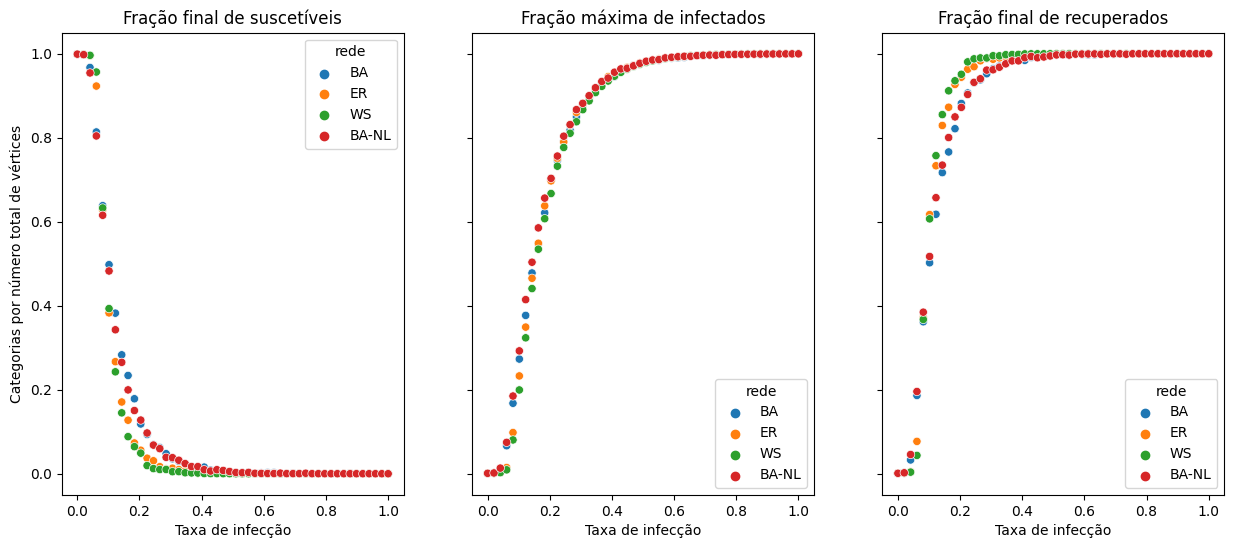

In [33]:
#Cria um gráfico de três partes para visualizar as frações obtidas para cada uma das categorias ("S", "I" e "R") do modelo.
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,6))

#Parte 1: Fração de suscetíveis
sns.scatterplot(x='beta', y='fracao_suscetiveis', hue='rede', data=df_res, ax=ax[0])
ax[0].set_title('Fração final de suscetíveis')
ax[0].set_xlabel('Taxa de infecção')
ax[0].set_ylabel('Categorias por número total de vértices')

#Parte 2: Fração de infectados
sns.scatterplot(x='beta', y='fracao_infectados', hue='rede', data=df_res, ax=ax[1])
ax[1].set_title('Fração máxima de infectados')
ax[1].set_xlabel('Taxa de infecção')

#Parte 3: Fração de recuperados
sns.scatterplot(x='beta', y='fracao_recuperados', hue='rede', data=df_res, ax=ax[2])
ax[2].set_title('Fração final de recuperados')
ax[2].set_xlabel('Taxa de infecção')

plt.show()

Comparando com o resultado obtido no caso Markoviano da seção "Modelo SIR", duas diferenças se fazem claras: a primeira é um aumento significativo da fração de infectados e recuperados proporcional ao aumento na taxa de infecção, que se mantia abaixo de 1.0 no caso anterior, além de um decréscimo mais rápido na fração de suscetíveis; a segunda é uma maior uniformidade no comportamento das redes testadas, com as diferentes topologias não impactando tão significativamente quanto anteriormente.

# Extra - Regressão utilizando propriedades da rede

Primeiro, vamos definir algumas funções para salvar as propriedades das redes:

In [ ]:
def acc(rede):
  '''
  Calcula a acessibilidade de um grafo G de acordo com a refência
  https://journals.aps.org/pre/abstract/10.1103/PhysRevE.90.032812
  '''
  vk = dict(rede.degree())
  vk = list(vk.values())
  A = nx.adjacency_matrix(rede)
  N = len(rede)
  P = np.zeros((N,N), dtype = 'float')
  for i in np.arange(0, N):
    for j in np.arange(0, N):
      if(vk[i] > 0):
        P[i,j] = A[i,j]/vk[i]     #calcula as probabilidades
  P2 = sp.linalg.expm(P)/np.exp(1)
  vacc = np.zeros(N, dtype = float)
  for i in np.arange(0, N):
    acc = 0
    for j in np.arange(0,N):
      if(P2[i,j] > 0):
        acc = acc + P2[i,j]*np.log(P2[i,j])     #aplica a fórmula final com os valores de probabilidade.
    acc = np.exp(-acc)
    vacc[i] = acc

  return vacc

In [ ]:
def caracteristicas_das_redes(rede, beta, mu):
  '''
  Aplica o cálculo de medidas de interesse para a rede sendo estudada. Nessa versão,
  -> são calculadas as centralidades de grau, betweeness e proximidade, além do grau médio dos vizinhos,
  -> acessiblidade, grau do vértice e clustering.

  -> rede: a rede a ser usada. A entrada esperada é nx.Graph().
  -> betas: lista com os valores de beta, ou taxa de transmissão, para rodar a simulação.
  -> mu: taxa de recuperação dos vértices. Valor único.
  '''

  #Características das redes que serão estudadas
  cent_grau = []
  cent_betweeness = []
  cent_prox = []
  grau_medio_vizinhos = []
  vetor_grau_vertice = []

  #Para a epidemia SIR
  S_aux = []
  I_aux = []
  R_aux = []

  swp_dc = nx.degree_centrality(rede)       #calcula a centralidade de grau
  swp_bc = nx.betweenness_centrality(rede)  #calcula a centralidade betweeness
  swp_cb = nx.closeness_centrality(rede)    #calcula a centralidade de proximidade

  for node in (rede.nodes):    #extrai o grau de cada vértice, suas centralidades e aplica a epidemia SIR
    vetor_grau_vertice.append(nx.degree(rede, node))
    cent_grau.append( swp_dc.get(node) )
    cent_betweeness.append( swp_bc.get(node) )
    cent_prox.append( swp_cb.get(node) )
    vt, vS, vI, vR = EoN.Gillespie_SIR(rede, beta, mu, initial_infecteds = node)
    S_aux.append( vS[len(vS)-1]/len(rede.nodes()) )
    I_aux.append( max(vI)/len(rede.nodes()) )
    R_aux.append( vR[len(vR)-1]/len(rede.nodes()) )

  #Computes the accessibility of each node in this graph and save results
  acc_rede = acc(rede)

  #Also, computes the clustering coefficients for each node
  clustering_coeff = list(nx.clustering(rede).values())

  #Por fim, extrai o grau médio dos vizinhos de cada um dos vértices da rede
  for i in rede.nodes():
    aux =  nx.average_neighbor_degree(rede, nodes = [i])
    grau_medio_vizinhos.append(float(aux[i]))
  grau_medio_vizinhos = np.array(grau_medio_vizinhos)

  res_columns = np.arange(0, len(rede), 1) #reescreve as colunas para criar o dataframe

  d = {'fracao_suscetiveis': S_aux, 'fracao_infectados': I_aux, 'fracao_recuperados': R_aux,
       'grau_vertice': vetor_grau_vertice, 'cent_grau': cent_grau, 'cent_betweeness':cent_betweeness,
        'cent_prox': cent_prox, 'acessibilidade': acc_rede, 'clustering': clustering_coeff,
        'grau_medio_vizinhos': grau_medio_vizinhos}

  df = pd.DataFrame(data=d)
  df.index = res_columns

  return df

In [ ]:
#Código para aplicar o teste de importância de características, ou feature importance.

def aplica_feature_importance(data, caracteristicas, objetivo, tam_teste=0.3, divisoes=7, random_state=42):
  '''
  Os melhores parâmetros para o modelo são definidos através de GridSearch automaticamente. Para verificar,
  -> use print(melhores_parâmetros).

  -> data: DataFrame generated using one of the functions implemented to run SINDy
  -> caracteristicas: features to test in this regressor
  -> objetivo: "target" for the random forest algorithm (array from original dataframe).
  -> tam_teste: for the train_test_split() function. Default: 0.25
  -> divisoes: partições do conjunto de dados que deverá ser utilizada. Padrão: 1000 valores em cada rede (para cada vértice) * tam_teste / 100
  -> random_state: can be anything. Default: sim_par.set_seed
  '''

  X = data[caracteristicas]
  y = np.ravel(objetivo)

  #Cria os conjuntos de treino e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tam_teste, random_state=random_state)

  #Aplica GridSearch para encontrar o melhor modelo de RandomForest para esse estudo
  param_grid = {'n_estimators': [20,50,100,150,200,250,300], 'max_depth': [2,4,6,8,None]}
  sh = GridSearchCV(RandomForestRegressor(random_state), param_grid, cv=divisoes).fit(X_train, y_train)
  melhor_modelo = sh.best_estimator_
  melhores_parametros = sh.best_params_   #não usado, está aqui por motivos de debugging.

  melhor_modelo.fit(X_train, y_train)
  perm_importance = permutation_importance(melhor_modelo, X_test, y_test)

  return melhor_modelo, perm_importance

In [ ]:
#Funções que farão os gráficos para definirmos o impacto de cada medida da rede.

def PlotFeatures(regressores, nomes):
  '''
  Grafica o resultado da função aplica_feature_importance() para todas as redes testadas.
  -> regressores: lista com cada entrada sendo um dos modelos definidos pela função aplica_feature_importance()
  -> nomes: rótulos para as redes.
  '''

  fig, ax = plt.subplots(nrows=1, ncols=len(regressores), figsize=(15,8), sharex=True, sharey=True)    #tamanho de colunas adaptável
  contador = 0
  for regressor in regressores:
    colors = sns.color_palette("flare", int(len(regressor.feature_importances_)+1))   #paleta de cores
    rank = list(range(0, len(regressor.feature_names_in_), 1))    #define a ordem das características.

    sorted_idx = (-regressor.feature_importances_).argsort()    #sorteia as características.
    sns.barplot(x=regressor.feature_importances_[sorted_idx],
                y=regressor.feature_names_in_[sorted_idx], palette=np.array(colors[::-1])[rank], ax=ax[contador])
    ax[contador].set_title(nomes[contador])
    contador = contador+1

def PlotPermutationImportance(regressores, perm_importance, nomes):
  '''
  Grafica o resultado da função aplica_feature_importance() para todas as redes testadas.
  -> A diferença dessa função para a anterior é o uso dos resultados de permutation importance.

  -> regressores: lista com cada entrada sendo um dos modelos definidos pela função aplica_feature_importance()
  -> nomes: rótulos para as redes.
  '''

  fig, ax = plt.subplots(nrows=1, ncols=len(regressores), figsize=(15,8), sharex=True, sharey=True)
  contador = 0
  for regressor in regressores:
    colors = sns.color_palette("flare", int(len(regressor.feature_importances_)+1))
    rank = list(range(0, len(regressor.feature_names_in_), 1))

    sorted_idx = (-perm_importance[contador].importances_mean).argsort()
    sns.barplot(x=perm_importance[contador].importances_mean[sorted_idx],
                y=regressor.feature_names_in_[sorted_idx], palette=np.array(colors[::-1])[rank], ax=ax[contador])
    ax[contador].set_title(nomes[contador])
    contador = contador+1

In [ ]:
#Executa a simulação para cada tipo de rede.
#--- Parâmetros ---:
beta = 0.5
mu = 1
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']
df_caracteristicas = pd.DataFrame()

for n in range(len(todas_redes)):
  print('---> Calculando para a rede', net_nomes[n])
  aux = caracteristicas_das_redes(todas_redes[n], beta, mu)
  #Abaixo, adiciona uma lista com rótulos de tamanho len(betas), ou tamanho resultante
  #-> do dataframe, contendo o nome de cada rede usada.
  aux['rede'] = np.tile(net_nomes[n], len(aux))

  df_caracteristicas = pd.concat([df_caracteristicas, aux])

#Puxa a última coluna, contendo o nome da rede, para o início:
cols = df_caracteristicas.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_caracteristicas = df_caracteristicas[cols]

---> Calculando para a rede BA
---> Calculando para a rede ER
---> Calculando para a rede WS
---> Calculando para a rede BA-NL


In [ ]:
df_caracteristicas

,rede,fracao_suscetiveis,fracao_infectados,fracao_recuperados,grau_vertice,cent_grau,cent_betweeness,cent_prox,acessibilidade,clustering,grau_medio_vizinhos
0,BA,0.009,0.650,0.991,191,0.191191,0.065739,0.549807,90.346668,0.048829,31.753927
1,BA,0.007,0.627,0.993,62,0.062062,0.008345,0.477533,63.428669,0.060286,35.500000
2,BA,0.004,0.597,0.996,60,0.060060,0.009539,0.488748,63.423207,0.076836,43.033333
3,BA,0.002,0.630,0.998,62,0.062062,0.008649,0.480751,63.552555,0.071920,40.129032
4,BA,0.006,0.615,0.994,20,0.020020,0.001156,0.427288,41.392007,0.110526,56.200000
...,...,...,...,...,...,...,...,...,...,...,...
995,BA-NL,0.003,0.654,0.997,10,0.010010,0.000152,0.360650,30.118574,0.022222,25.800000
996,BA-NL,0.003,0.657,0.997,10,0.010010,0.000245,0.386460,31.021117,0.133333,53.900000
997,BA-NL,0.007,0.632,0.993,10,0.010010,0.000173,0.388414,31.829236,0.133333,57.900000
998,BA-NL,0.009,0.640,0.991,10,0.010010,0.000196,0.387510,32.188291,0.177778,55.600000


In [ ]:
#Impacto para a fração do máximo de vértices infectados, que é uma maneira de verificar
#-> quão eficientemente cada característica contribui para a propagação da epidemia.

fts = list(df_caracteristicas.columns)[4:]    #as primeiras três colunas são as frações e o nome das redes.
regressores = []
perms = []
todas_redes = [BA_graph, ER_graph, WS_graph, BA_nl_graph]
net_nomes = ['BA', 'ER', 'WS', 'BA-NL']

for n in range(len(todas_redes)):
  print('---> Calculando para a rede', net_nomes[n])
  df = df_caracteristicas.loc[df_caracteristicas['rede'] == net_nomes[n]]
  modelo, modelo_perm = aplica_feature_importance(df, fts, df['fracao_infectados'], 0.3, 7, random_state=42)
  regressores.append(modelo)
  perms.append(modelo_perm)

---> Calculando para a rede BA
---> Calculando para a rede ER
---> Calculando para a rede WS
---> Calculando para a rede BA-NL


O método de Permutation Importance embaralha de maneira aleatória cada uma das características contidas na tabela de dados e então computa mudanças na performance do modelo. As características que impactam mais nessa performance serão então as mais importantes.

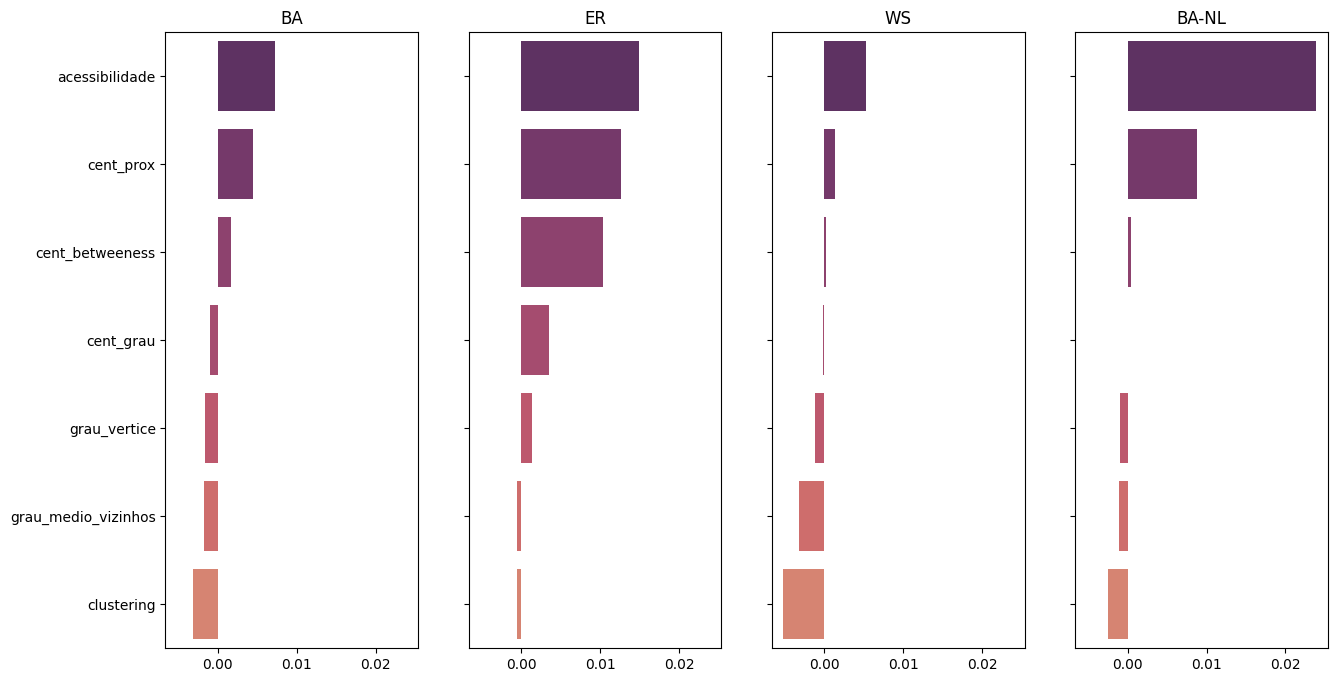

In [ ]:
PlotPermutationImportance(regressores, perms, net_nomes)

Os valores de *feature importance* são calculados com medida de importância usando a formulação Gini.

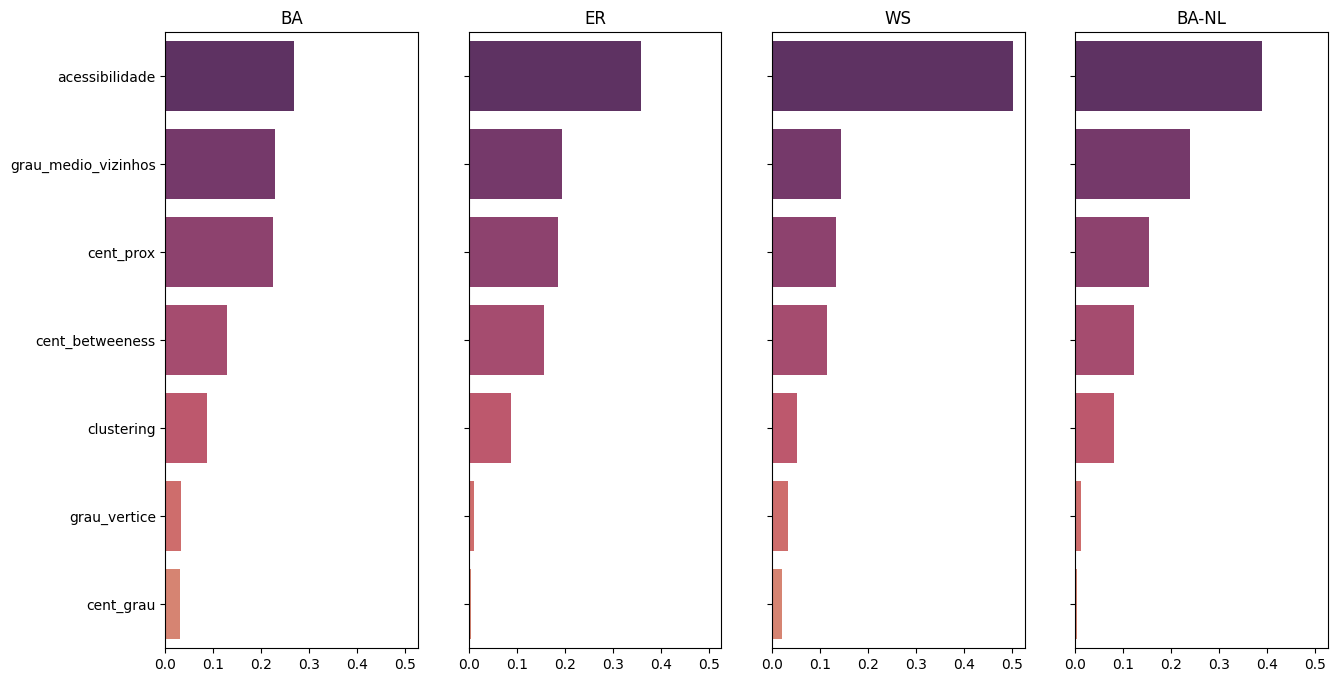

In [ ]:
PlotFeatures(regressores, net_nomes)

Em ambos resultados, podemos ver que a acessibilidade, que mede quão fácil é acessar um dado vértice a partir de um qualquer da rede, é a que mais contribui para a propagação da epidemia em todas as topologias. Em segundo lugar, vem o grau médio dos vizinhos, mostrando que vizinhos mais conectados afetam mais a rede como um todo. Ambos são resultados esperados.

# Informações sobre o computador onde o código foi executado

Para situar os tempos de simulação, caso deseje executar as células.

Processador: AMD Ryzen 5600X,

Placa de vídeo: Geforce RTX 2060S

RAM: Corsair 16Gb, 3200MHz

Armazenamento: SSD M2 1Tb, Gen 3, 3500 Mb/s.